In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import seaborn as sns

from theano import shared

In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

In [3]:
import sys, IPython, scipy, matplotlib, pandas, seaborn, patsy, platform, theano
print("""This notebook was created using:\nPython {}\nIPython {}\nPyMC3 {}\nArviZ {}\nNumPy {}\nSciPy {}\nPandas {}\nSeaborn {}\nPatsy {}\nMatplotlib {}\nTheano {}\n""".format(sys.version[:5], IPython.__version__, pm.__version__, az.__version__, np.__version__, scipy.__version__, pandas.__version__, seaborn.__version__, patsy.__version__, matplotlib.__version__, theano.__version__))

This notebook was created using:
Python 3.7.4
IPython 7.13.0
PyMC3 3.8
ArviZ 0.7.0
NumPy 1.18.2
SciPy 1.4.1
Pandas 1.0.3
Seaborn 0.10.0
Patsy 0.5.1
Matplotlib 3.2.1
Theano 1.0.4



# Chapter 5 The Many Variables & The Spurious Waffles

Using multiple regression to deal with simple confounds and to take multiple measurements of association. 

## 5.1. Spurious association

### Code 5.1 - Code 5.6

In [4]:
# load waffle & divoce data
d = pd.read_csv("Data/WaffleDivorce.csv", sep=";", header=0)
d.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


In [5]:
# standardize the variables of interest
d['MedianAgeMarriage_std'] = (d.MedianAgeMarriage-d.MedianAgeMarriage.mean())/d.MedianAgeMarriage.std()
d['Marriage_std'] = (d.Marriage-d.Marriage.mean())/d.Marriage.std()
d['Divorce_std'] = (d.Divorce-d.Divorce.mean())/d.Divorce.std()
d.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,MedianAgeMarriage_std,Marriage_std,Divorce_std
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45,-0.606290,0.022644,1.654205
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00,-0.686699,1.549802,1.544364
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00,-0.204241,0.048974,0.610716
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26,-1.410387,1.655123,2.093569
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00,0.599857,-0.266989,-0.927058


In [6]:
d.MedianAgeMarriage.std()

1.2436303013880823

In [7]:
# define model Divorce-MedianAgeMarriage
with pm.Model() as m_5_1a:
    a = pm.Normal('a', mu=0, sigma=0.2)
    b_A = pm.Normal('b_A', mu=0, sigma=0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + b_A*d.MedianAgeMarriage_std)
    Divorce = pm.Normal('Divorce', mu=mu, sigma=sigma, observed=d.Divorce_std)
    trace_m_5_1a = pm.sample(1000, tune=1000)

# show model summary
varnames = ['~mu']
az.summary(trace_m_5_1a, varnames, kind="stats", round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_A, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:01<00:00, 4845.41draws/s]


,mean,sd,hpd_3%,hpd_97%
a,0.00,0.10,-0.18,0.20
b_A,-0.57,0.12,-0.78,-0.34
sigma,0.82,0.08,0.67,0.98


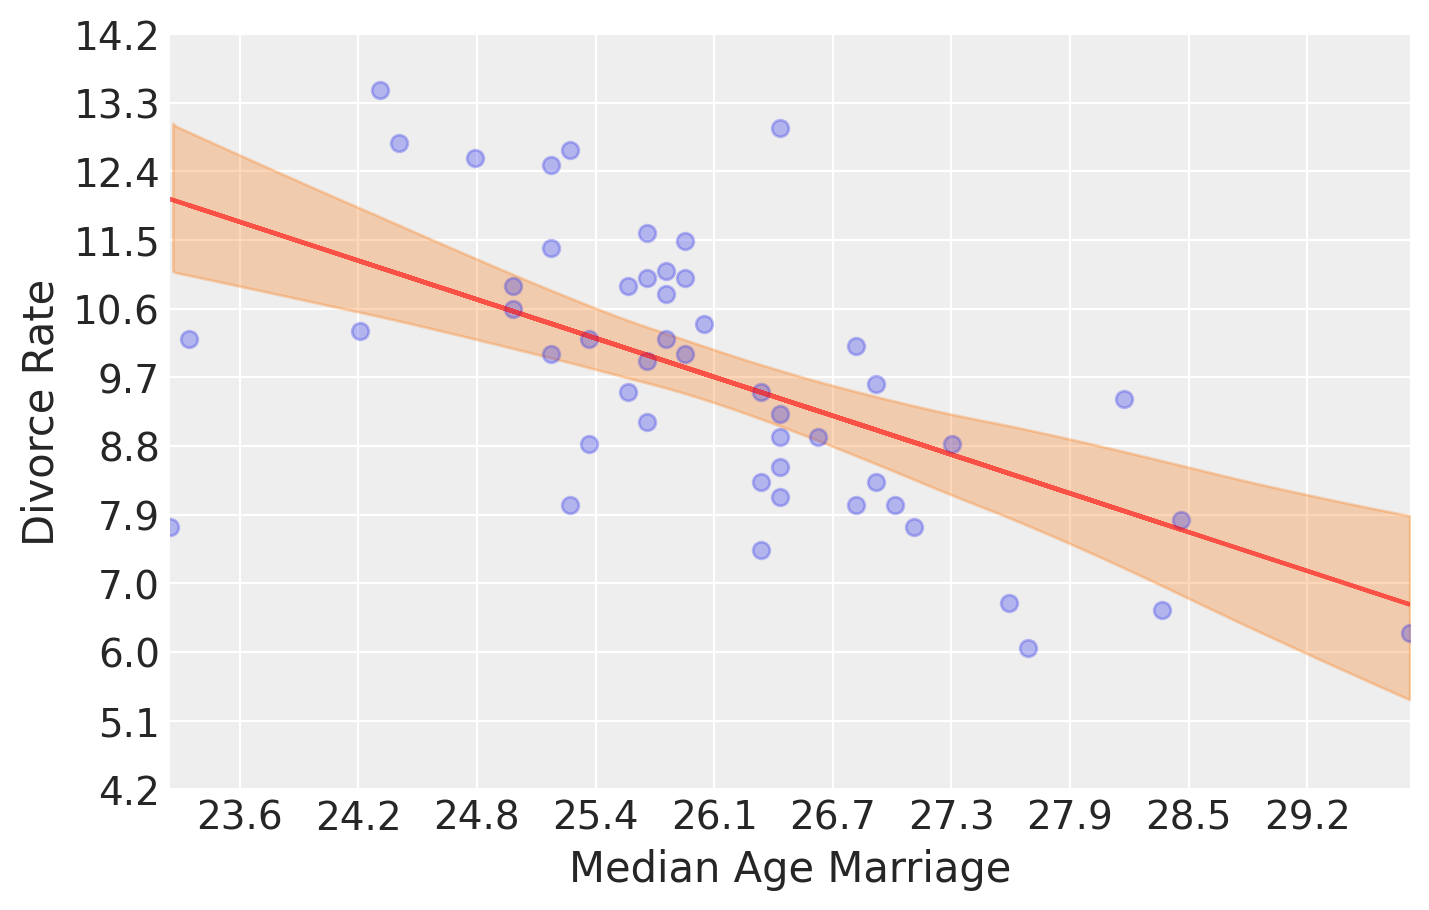

In [8]:
# calculate predicted mean
mu_pred = trace_m_5_1a["mu"]

# plot results
fig = plt.figure(figsize=(8, 5))
plt.plot(d.MedianAgeMarriage_std, d.Divorce_std, 'o', alpha=0.3)
# mean
plt.plot(d.MedianAgeMarriage_std, mu_pred.mean(0), "r", alpha=0.6)
# CI for mean
az.plot_hpd(d.MedianAgeMarriage_std, mu_pred, color='C1', fill_kwargs={'alpha': 0.3})
plt.ylabel('Divorce Rate', fontsize=15)
plt.xlabel('Median Age Marriage', fontsize=15)
at = np.arange(-3, 3, 0.5)
plt.xticks(at, np.round(at * d.MedianAgeMarriage.std() + d.MedianAgeMarriage.mean(), 1));
plt.yticks(at, np.round(at * d.Divorce.std() + d.Divorce.mean(), 1));
plt.xlim(d.MedianAgeMarriage_std.min(), d.MedianAgeMarriage_std.max())
plt.show()

In [9]:
# define model Divorce-Marriage
with pm.Model() as m_5_1b:
    a = pm.Normal('a', mu=0, sigma=0.2)
    b_M = pm.Normal('b_M', mu=0, sigma=0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + b_M*d.Marriage_std)
    Divorce = pm.Normal('Divorce', mu=mu, sigma=sigma, observed=d.Divorce_std)
    trace_m_5_1b = pm.sample(1000, tune=1000)

# show model summary
varnames = ['~mu']
az.summary(trace_m_5_1b, varnames, kind="stats", round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_M, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:01<00:00, 4766.44draws/s]


,mean,sd,hpd_3%,hpd_97%
a,-0.00,0.11,-0.23,0.19
b_M,0.35,0.14,0.10,0.60
sigma,0.95,0.10,0.77,1.14


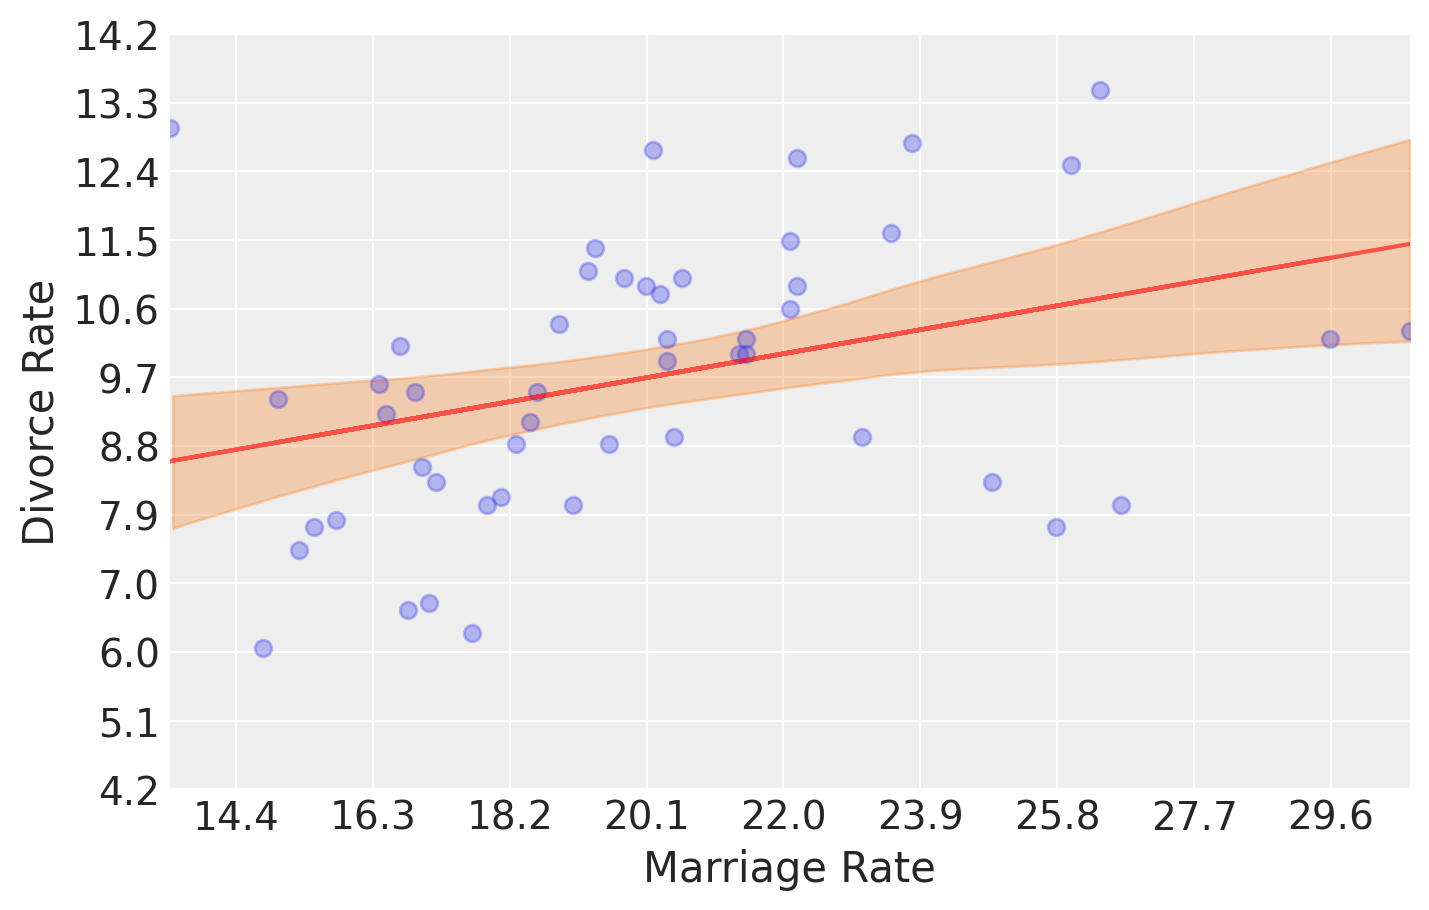

In [10]:
# calculate predicted mean
mu_pred = trace_m_5_1b["mu"]

# plot results
fig = plt.figure(figsize=(8, 5))
plt.plot(d.Marriage_std, d.Divorce_std, 'o', alpha=0.3)
# mean
plt.plot(d.Marriage_std, mu_pred.mean(0), "r", alpha=0.6)
# CI for mean
az.plot_hpd(d.Marriage_std, mu_pred, color='C1', fill_kwargs={'alpha': 0.3})
plt.ylabel('Divorce Rate', fontsize=15)
plt.xlabel('Marriage Rate', fontsize=15)
at = np.arange(-3, 3, 0.5)
plt.xticks(at, np.round(at * d.Marriage.std() + d.Marriage.mean(), 1));
plt.yticks(at, np.round(at * d.Divorce.std() + d.Divorce.mean(), 1));
plt.xlim(d.Marriage_std.min(), d.Marriage_std.max())
plt.show()

### Code 5.4

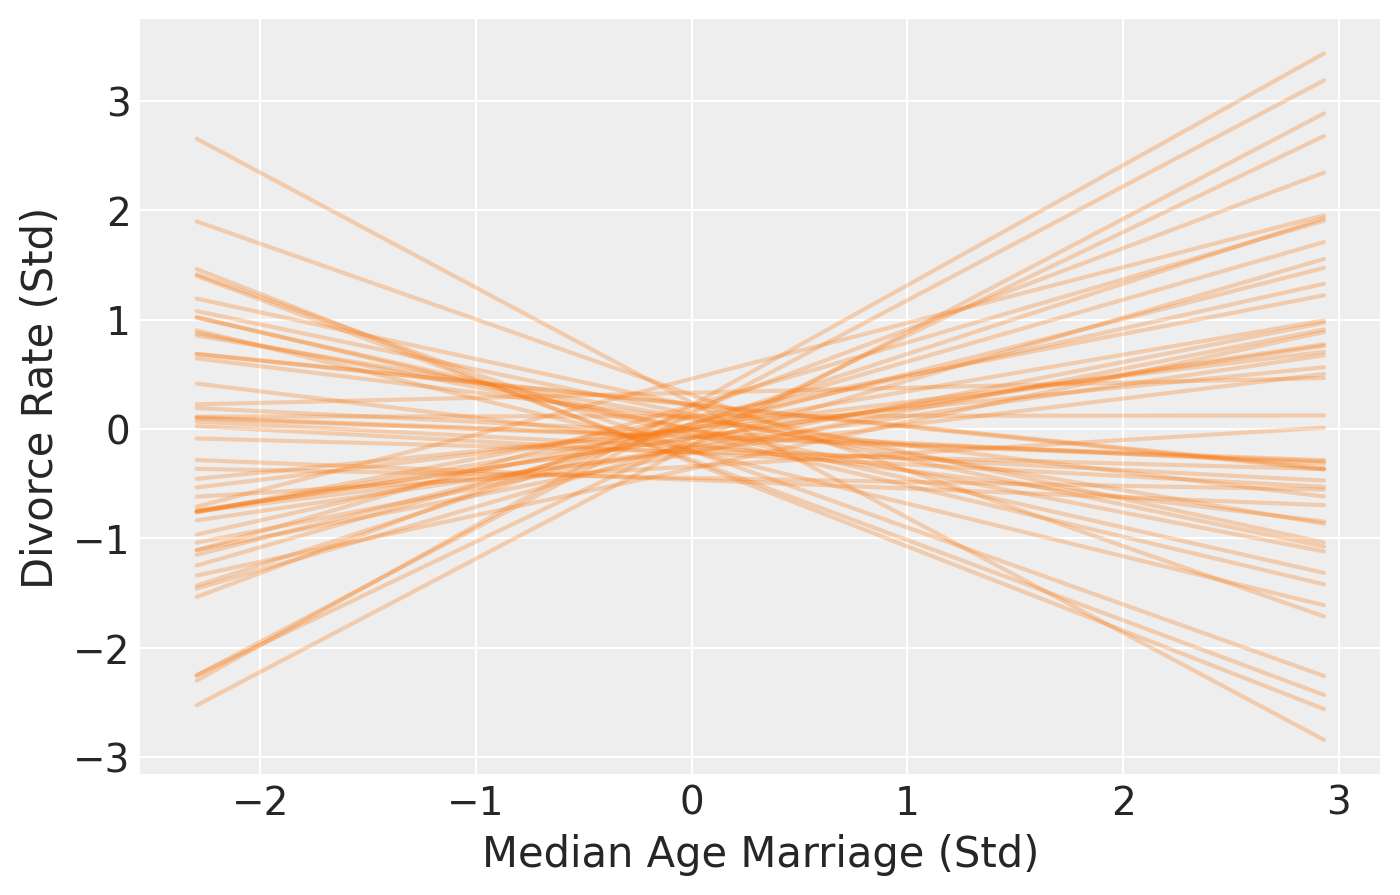

In [11]:
# draw samples from prior
n_samples = 1000
sample_a = stats.norm.rvs(loc=0, scale=0.2, size=n_samples)
sample_b_A = stats.norm.rvs(loc=0, scale=0.5, size=n_samples)

# generate data sequence 
age_seq = np.linspace(d.MedianAgeMarriage_std.min(), d.MedianAgeMarriage_std.max(), 50)
# init saving space
mu_pred = np.zeros((len(age_seq), n_samples))
# calculate posterior for each mu
for n, w in enumerate(age_seq):
    mu_pred[n] = sample_a + sample_b_A*w

# plot results
fig = plt.figure(figsize=(8, 5))
plt.plot(age_seq, mu_pred[:,:50], "-C1", alpha=0.3)
plt.ylabel('Divorce Rate (Std)', fontsize=15)
plt.xlabel('Median Age Marriage (Std)', fontsize=15)
plt.show()   

### 5.1.1. Think before you regress

### Code 5.7

Drawing a DAG Visit http://www.dagitty.net/.

### 5.1.2. Testable implications

### Code 5.8 - Code 5.9

Drawing a DAG Visit http://www.dagitty.net/.

### 5.1.3. Multiple regression notation

### 5.1.4. Approximating the posterior

### Code 5.10

In [12]:
# define model Divorce-Marriage-MedianAgeMarriage
with pm.Model() as m_5_3:
    a = pm.Normal('a', mu=0, sigma=0.2)
    b_A = pm.Normal('b_A', mu=0, sigma=0.5)
    b_M = pm.Normal('b_M', mu=0, sigma=0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + b_A*d.MedianAgeMarriage_std + b_M*d.Marriage_std)
    Divorce = pm.Normal('Divorce', mu=mu, sigma=sigma, observed=d.Divorce_std)
    trace_m_5_3 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_M, b_A, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 3482.44draws/s]


In [13]:
# show model summary
varnames = ['~mu']
az.summary(trace_m_5_3, varnames, kind="stats", round_to=2)

,mean,sd,hpd_3%,hpd_97%
a,0.00,0.10,-0.19,0.19
b_A,-0.61,0.16,-0.89,-0.30
b_M,-0.06,0.16,-0.36,0.22
sigma,0.82,0.09,0.67,0.98


### Code 5.11

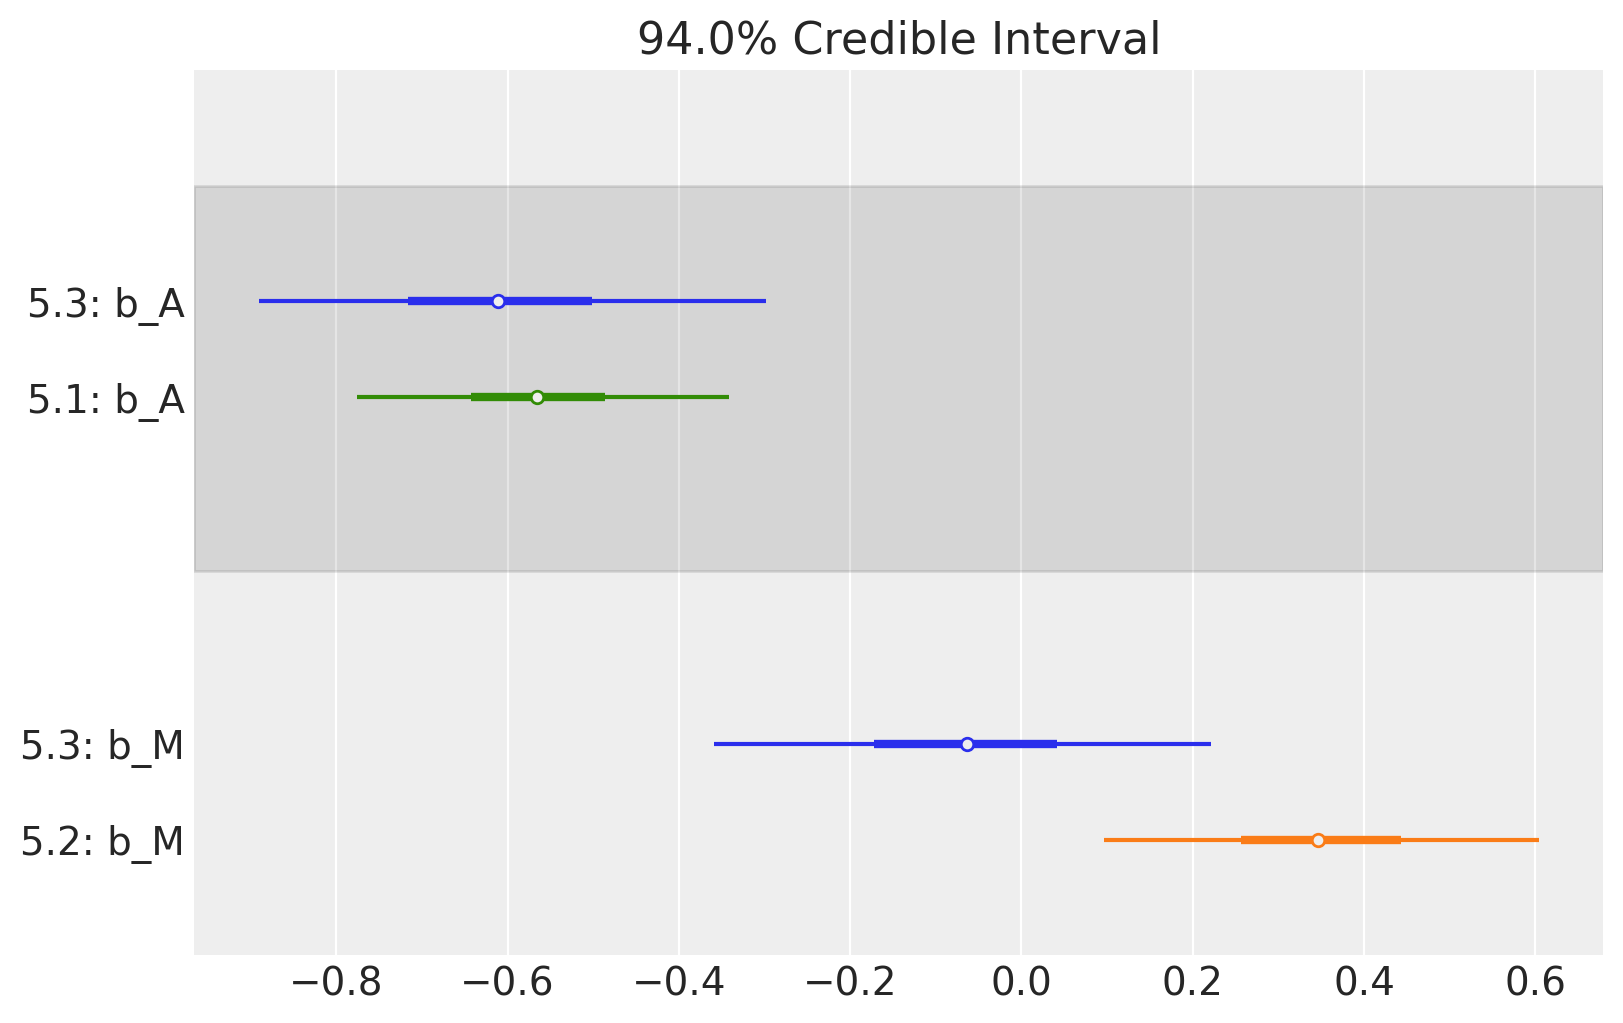

In [14]:
# plot results
axes = az.plot_forest(
    [trace_m_5_3, trace_m_5_1b, trace_m_5_1a],
    kind='forestplot',
    model_names=["5.3", "5.2", "5.1"],
    var_names=["b_A", "b_M"],
    combined=True,
    ridgeplot_overlap=3,
    credible_interval=0.94,
    figsize=(8, 5))

### Code 5.12

In [15]:
# simulating the divorce example
N = 50
age = stats.norm().rvs(N)
mar = stats.norm(-age).rvs(N)
div = stats.norm(age).rvs(N)

### 5.1.5. Plotting multivariate posteriors

### Code 5.13

In [16]:
# define model Marriage Rate
with pm.Model() as m_5_4a:
    a = pm.Normal('a', mu=0, sigma=0.2)
    b_A = pm.Normal('b_A', mu=0, sigma=0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + b_A*d.MedianAgeMarriage_std)
    M = pm.Normal('M', mu=mu, sigma=sigma, observed=d.Marriage_std)
    prior_samples_m_5_4a = pm.sample_prior_predictive(1000)
    trace_m_5_4a = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_A, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:01<00:00, 4389.43draws/s]


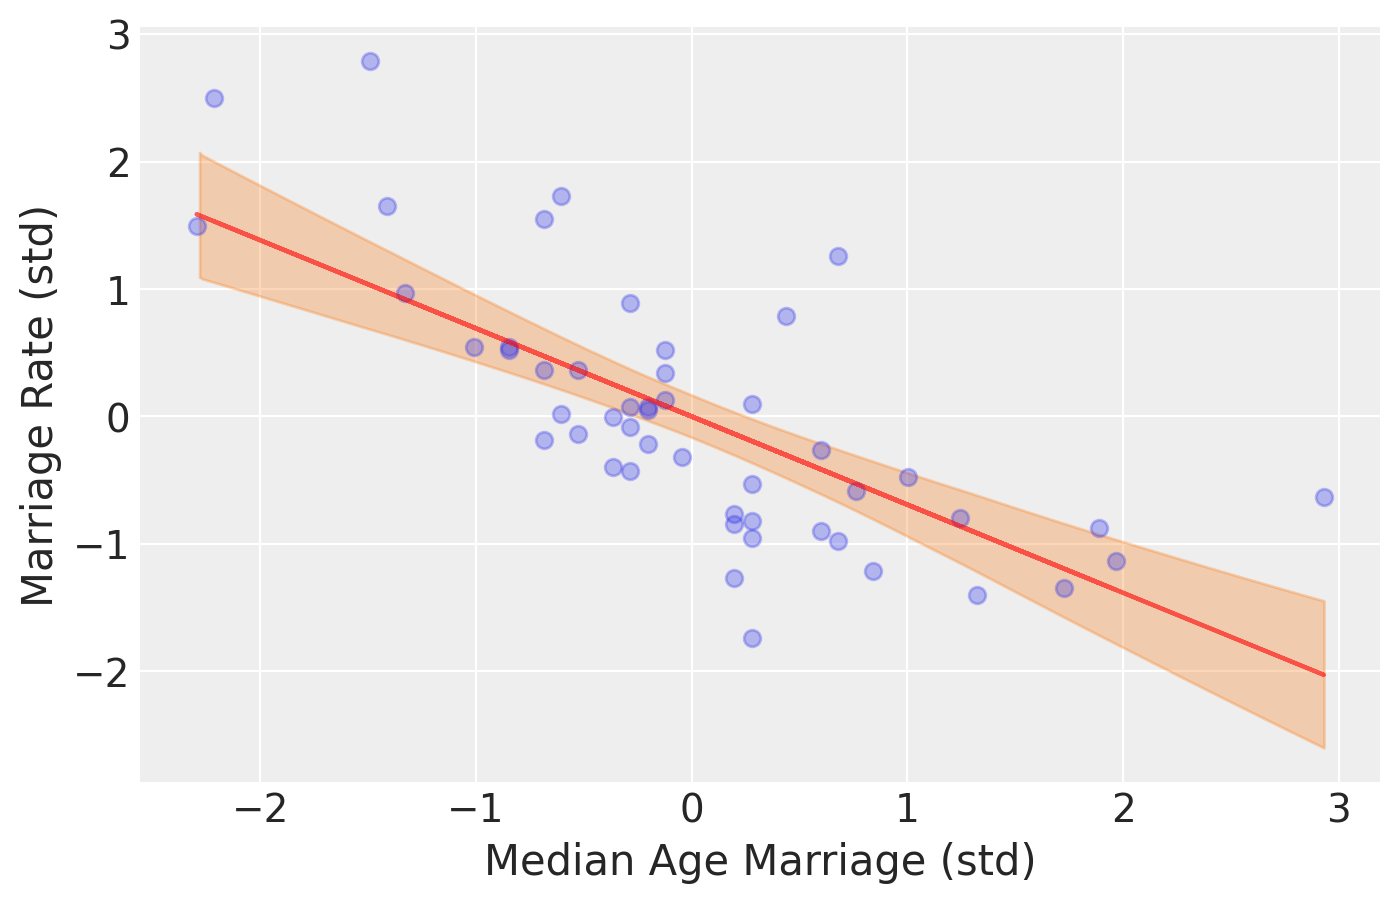

In [17]:
# plot results
fig = plt.figure(figsize=(8, 5))
plt.plot(d.MedianAgeMarriage_std, d.Marriage_std, 'o', alpha=0.3)
# mean
plt.plot(d.MedianAgeMarriage_std, trace_m_5_4a.mu.mean(0), "r", alpha=0.6)
# CI for mean
az.plot_hpd(d.MedianAgeMarriage_std, trace_m_5_4a.mu, color='C1', fill_kwargs={'alpha': 0.3})
plt.ylabel('Marriage Rate (std)', fontsize=15)
plt.xlabel('Median Age Marriage (std)', fontsize=15)
plt.show()

In [18]:
# define model Median Age Marriage
with pm.Model() as m_5_4b:
    a = pm.Normal('a', mu=0, sigma=0.2)
    b_M = pm.Normal('b_M', mu=0, sigma=0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + b_M*d.Marriage_std)
    A = pm.Normal('A', mu=mu, sigma=sigma, observed=d.MedianAgeMarriage_std)
    prior_samples_m_5_4b = pm.sample_prior_predictive(1000)
    trace_m_5_4b = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_M, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:01<00:00, 4256.82draws/s]


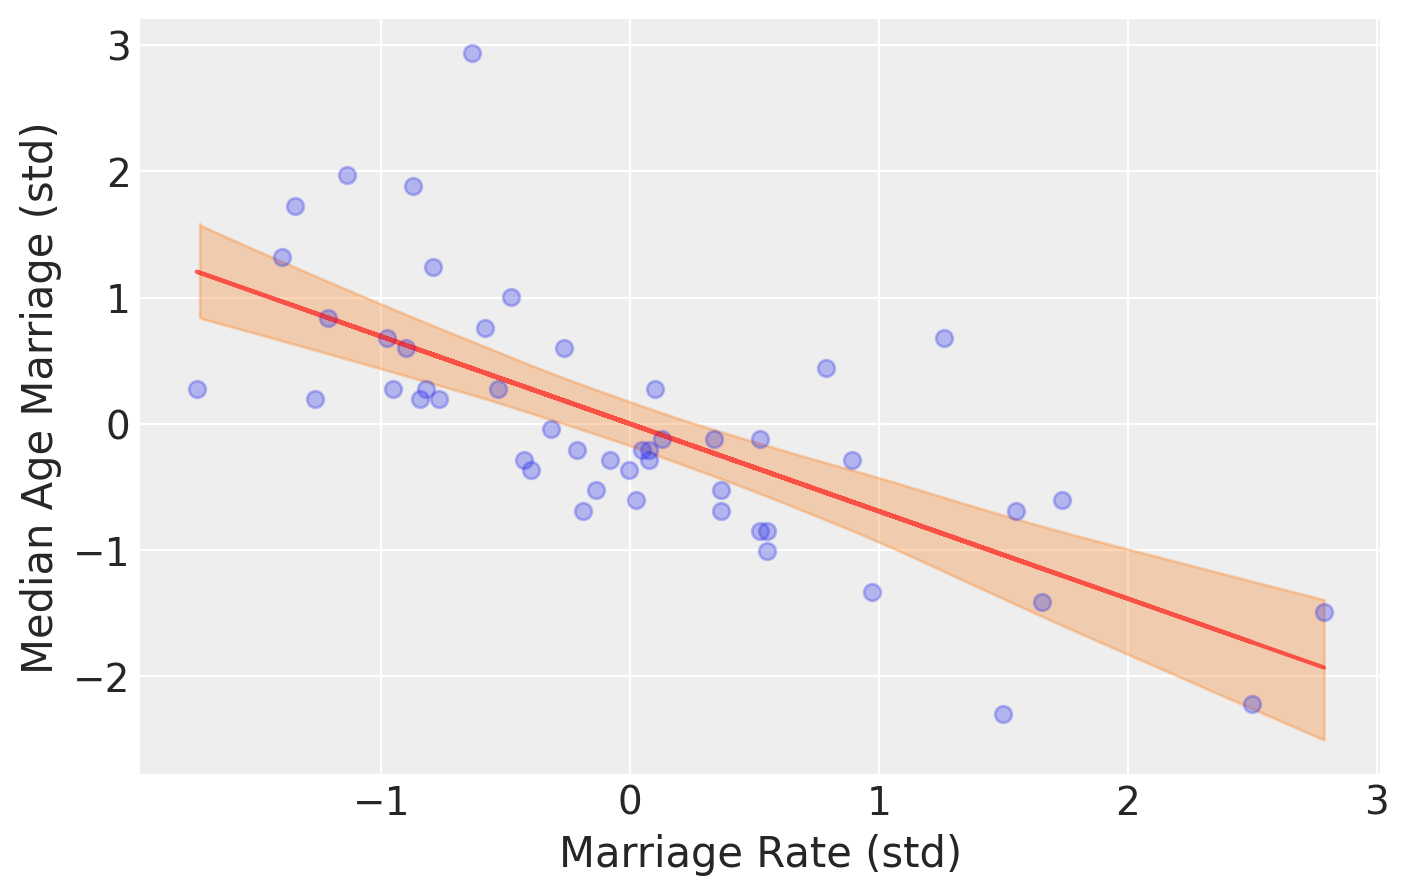

In [19]:
# plot results
fig = plt.figure(figsize=(8, 5))
plt.plot(d.Marriage_std, d.MedianAgeMarriage_std, 'o', alpha=0.3)
# mean
plt.plot(d.Marriage_std, trace_m_5_4b.mu.mean(0), "r", alpha=0.6)
# CI for mean
az.plot_hpd(d.Marriage_std, trace_m_5_4b.mu, color='C1', fill_kwargs={'alpha': 0.3})
plt.xlabel('Marriage Rate (std)', fontsize=15)
plt.ylabel('Median Age Marriage (std)', fontsize=15)
plt.show()

### Code 5.14

In [20]:
# compute the residuals
residuals_M = d.Marriage_std - trace_m_5_4a.mu.mean(0)
residuals_A = d.MedianAgeMarriage_std - trace_m_5_4b.mu.mean(0)

In [21]:
with pm.Model() as m_5_4c:
    a = pm.Normal('a', mu=0, sigma=0.2)
    b = pm.Normal('b', mu=0, sigma=0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + b*residuals_M)
    Divorce = pm.Normal('Divorce', mu=mu, sigma=sigma, observed=d.Divorce_std)
    prior_samples_m_5_4c = pm.sample_prior_predictive(1000)
    trace_m_5_4c = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:01<00:00, 4291.01draws/s]


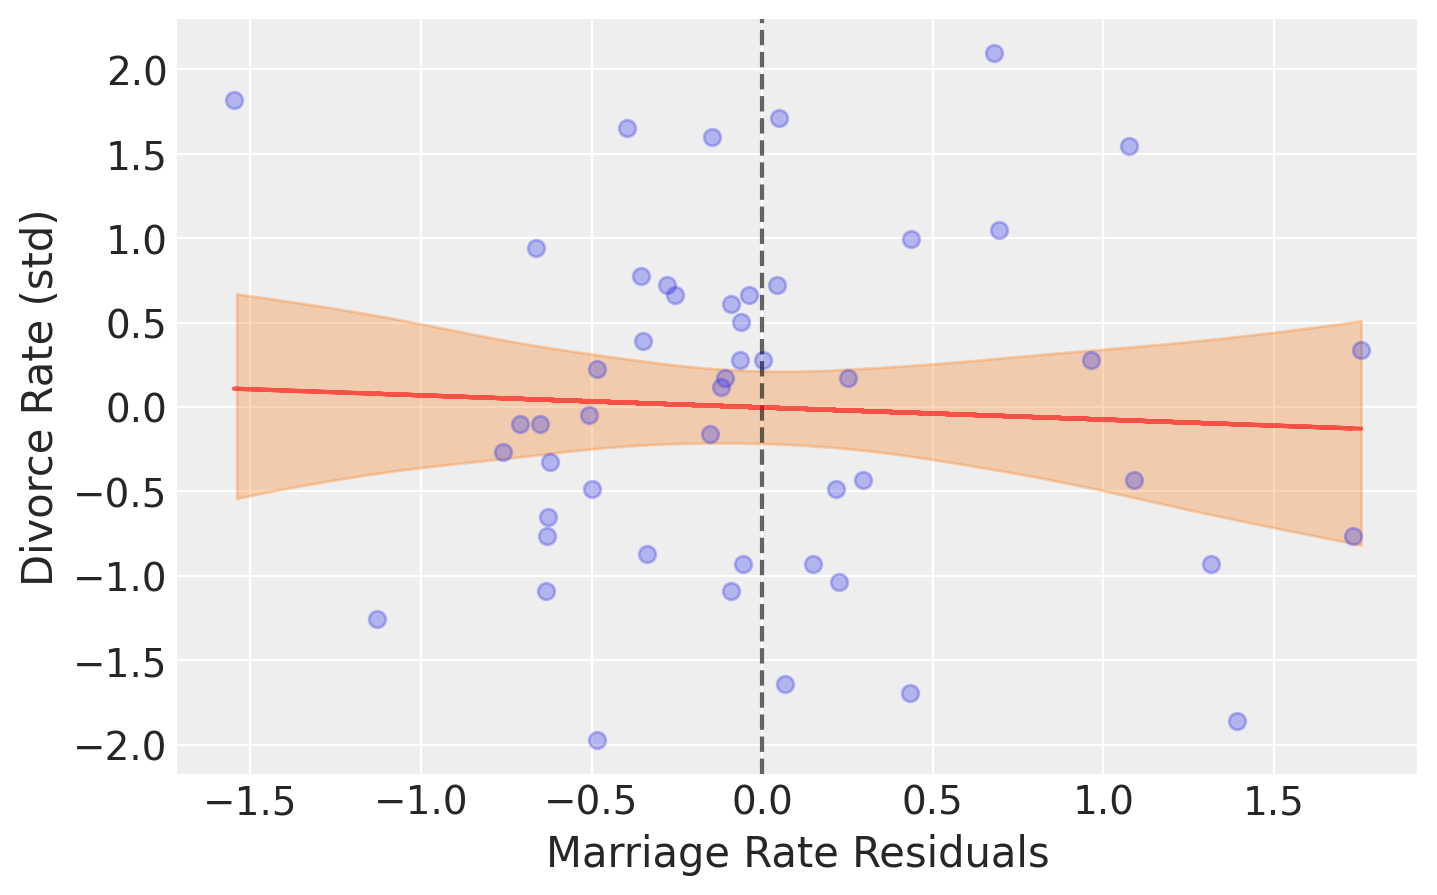

In [22]:
# plot results
fig = plt.figure(figsize=(8, 5))
plt.plot(residuals_M, d.Divorce_std, 'o', alpha=0.3)
plt.axvline(x=0, linestyle='--', color='k', alpha=0.6)
# mean
plt.plot(residuals_M, trace_m_5_4c.mu.mean(0), "r", alpha=0.6)
# CI for mean
az.plot_hpd(residuals_M, trace_m_5_4c.mu, color='C1', fill_kwargs={'alpha': 0.3})
plt.ylabel('Divorce Rate (std)', fontsize=15)
plt.xlabel('Marriage Rate Residuals', fontsize=15)
plt.show()

In [23]:
with pm.Model() as m_5_4d:
    a = pm.Normal('a', mu=0, sigma=0.2)
    b = pm.Normal('b', mu=0, sigma=0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + b*residuals_A)
    Divorce = pm.Normal('Divorce', mu=mu, sigma=sigma, observed=d.Divorce_std)
    prior_samples_m_5_4d = pm.sample_prior_predictive(1000)
    trace_m_5_4d = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:01<00:00, 4389.05draws/s]


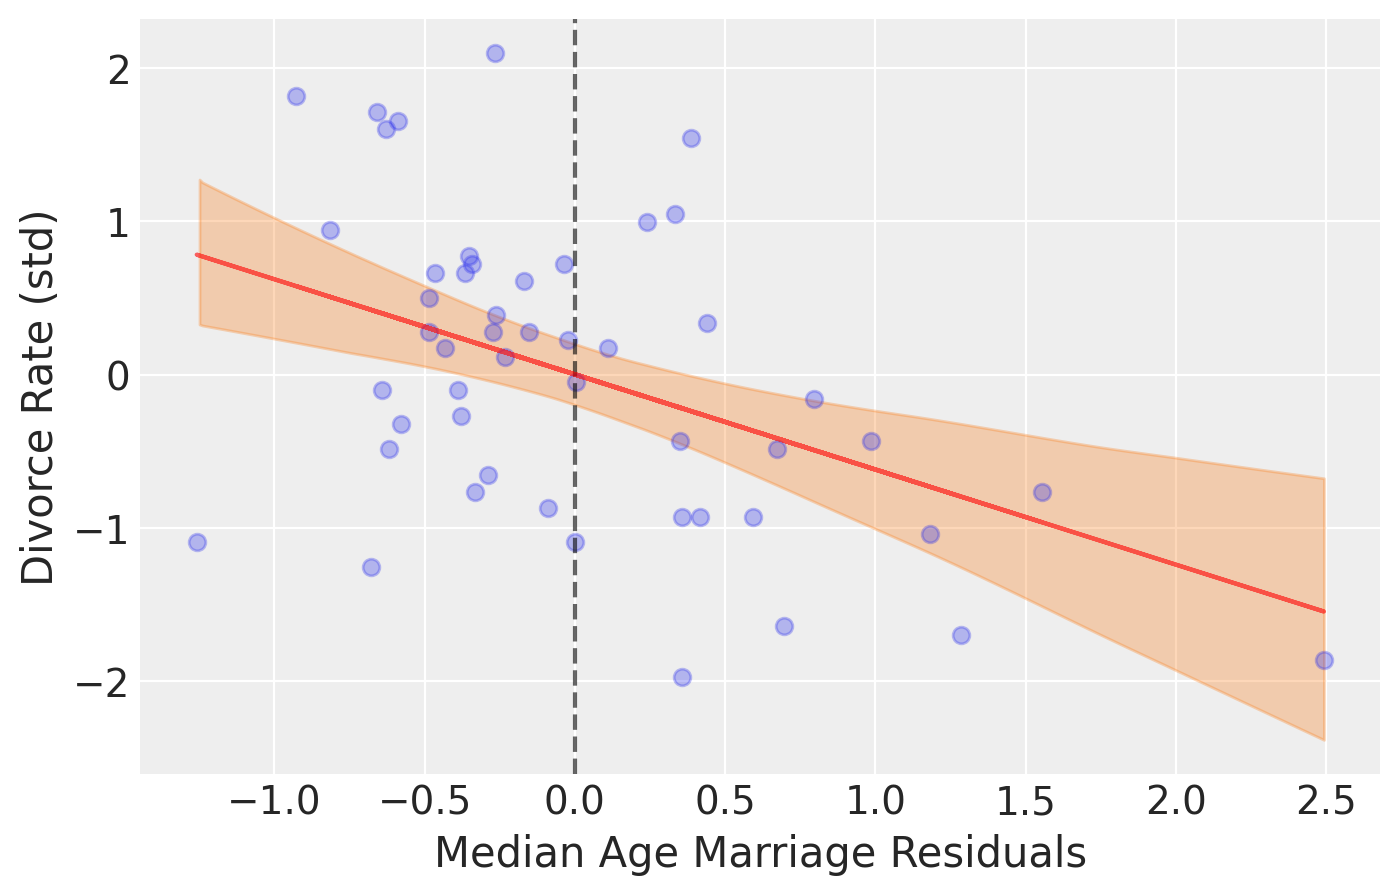

In [24]:
# plot results
fig = plt.figure(figsize=(8, 5))
plt.plot(residuals_A, d.Divorce_std, 'o', alpha=0.3)
plt.axvline(x=0, linestyle='--', color='k', alpha=0.6)
# mean
plt.plot(residuals_A, trace_m_5_4d.mu.mean(0), "r", alpha=0.6)
# CI for mean
az.plot_hpd(residuals_A, trace_m_5_4d.mu, color='C1', fill_kwargs={'alpha': 0.3})
plt.ylabel('Divorce Rate (std)', fontsize=15)
plt.xlabel('Median Age Marriage Residuals', fontsize=15)
plt.show()

### Code 5.15 - Code 5.17

In [25]:
# simulate observations
divorce_pred = pm.sample_posterior_predictive(trace=trace_m_5_3, 
                                              samples=1000, model=m_5_3)

/Users/yifei-wang/.pyenv/versions/3.7.4/envs/Statistical_Rethinking/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:01<00:00, 860.46it/s]


In [26]:
# summarize samples across cases
mu_mean = trace_m_5_3['mu'].mean(axis=0)
mu_CI = az.hpd(trace_m_5_3['mu'], credible_interval=0.89)

# simulate observations
divorce_mean = divorce_pred["Divorce"].mean(axis=0)
divorce_CI = az.hpd(divorce_pred["Divorce"], credible_interval=0.89)

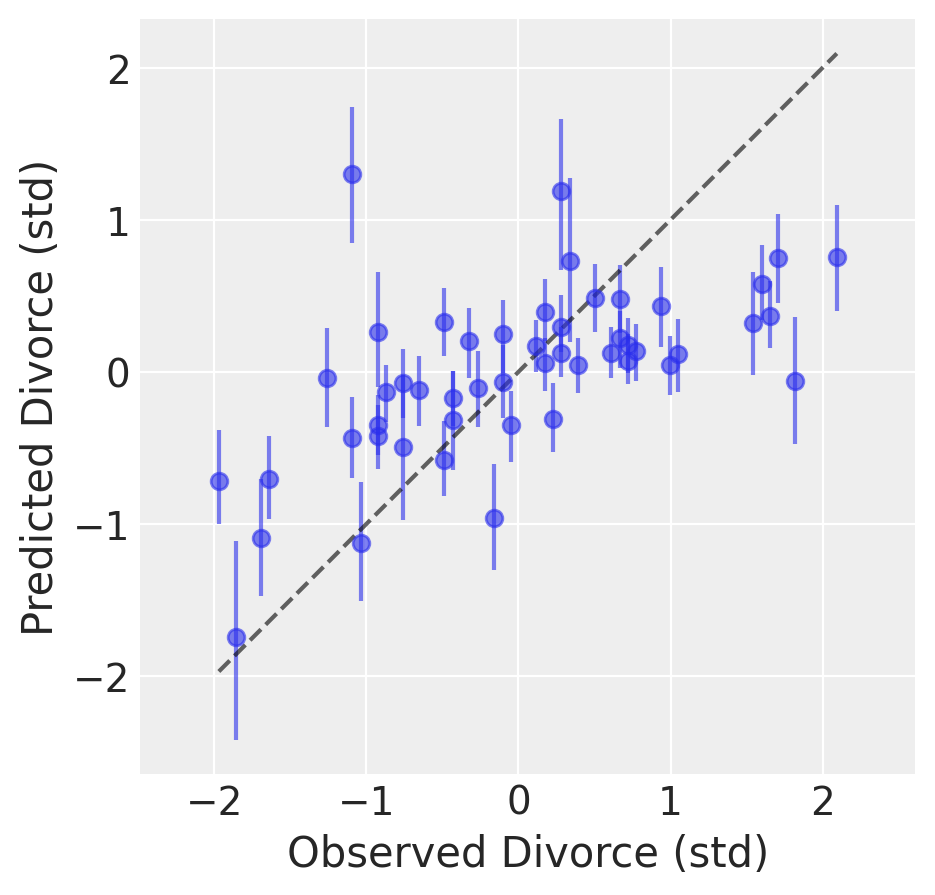

In [27]:
# plot results
fig = plt.figure(figsize=(5, 5))
plt.errorbar(
    d["Divorce_std"].values,
    mu_mean,
    yerr=np.abs(mu_mean-mu_CI.T),
    fmt="C0o",
    alpha=0.6)
min_x, max_x = d["Divorce_std"].min(), d["Divorce_std"].max()
plt.plot([min_x, max_x], [min_x, max_x], "k--", alpha=0.6)
plt.ylabel('Predicted Divorce (std)', fontsize=15)
plt.xlabel('Observed Divorce (std)', fontsize=15)
plt.axis("equal")
plt.show()

### Code 5.18

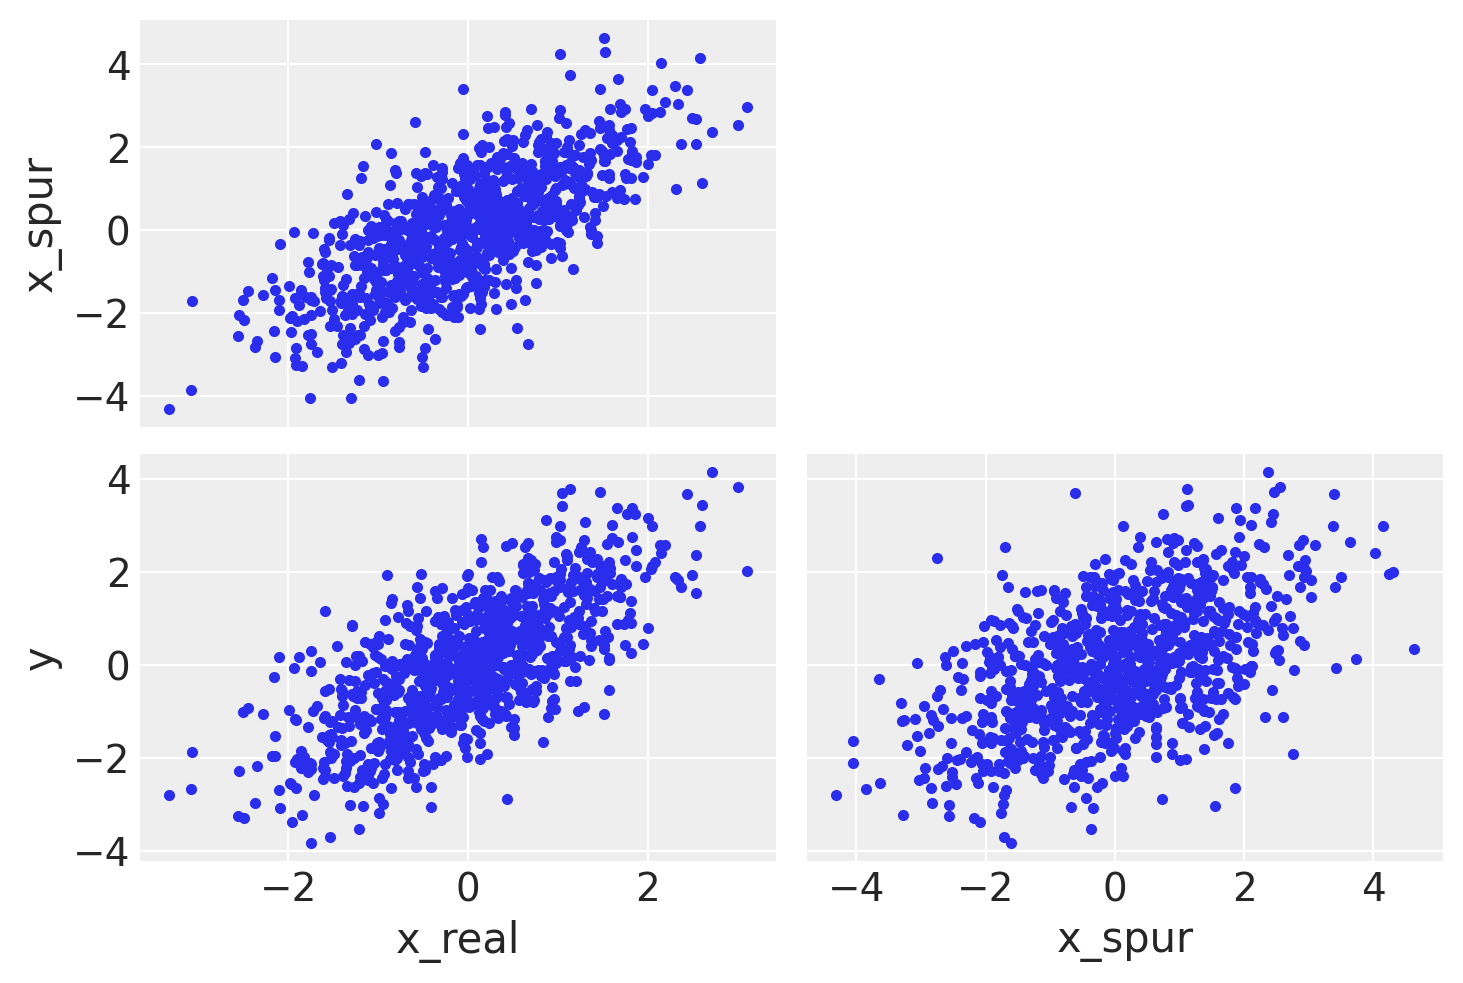

In [28]:
# simulating spurious association
N = 1000
x_real = stats.norm.rvs(loc=0, scale=1, size=N)
x_spur = stats.norm.rvs(loc=x_real, scale=1, size=N)
y = stats.norm.rvs(loc=x_real, scale=1, size=N)

# show plots
az.plot_pair({"x_real":x_real, "x_spur":x_spur, "y":y});

In [29]:
# standardize data
x_spur_std = (x_spur-x_spur.mean())/x_spur.std()
y_std = (y-y.mean())/y.std()

In [30]:
# define model y: x_real-x_spur
with pm.Model() as m_sim:
    a = pm.Normal("a", mu=0, sigma=0.2)
    b_real = pm.Normal("b_real", mu=0, sigma=0.5)
    b_spur = pm.Normal("b_spur", mu=0, sigma=0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + b_real*x_real + b_spur*x_spur)
    y_pred = pm.Normal("y_pred", mu=mu, sigma=sigma, observed=y_std)
    trace_m_sim = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_spur, b_real, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 2981.25draws/s]


In [31]:
# show model summary
varnames = ['~mu']
az.summary(trace_m_sim, varnames, kind="stats", round_to=2)

,mean,sd,hpd_3%,hpd_97%
a,-0.00,0.02,-0.04,0.04
b_real,0.69,0.03,0.63,0.75
b_spur,0.03,0.02,-0.02,0.07
sigma,0.70,0.02,0.67,0.73


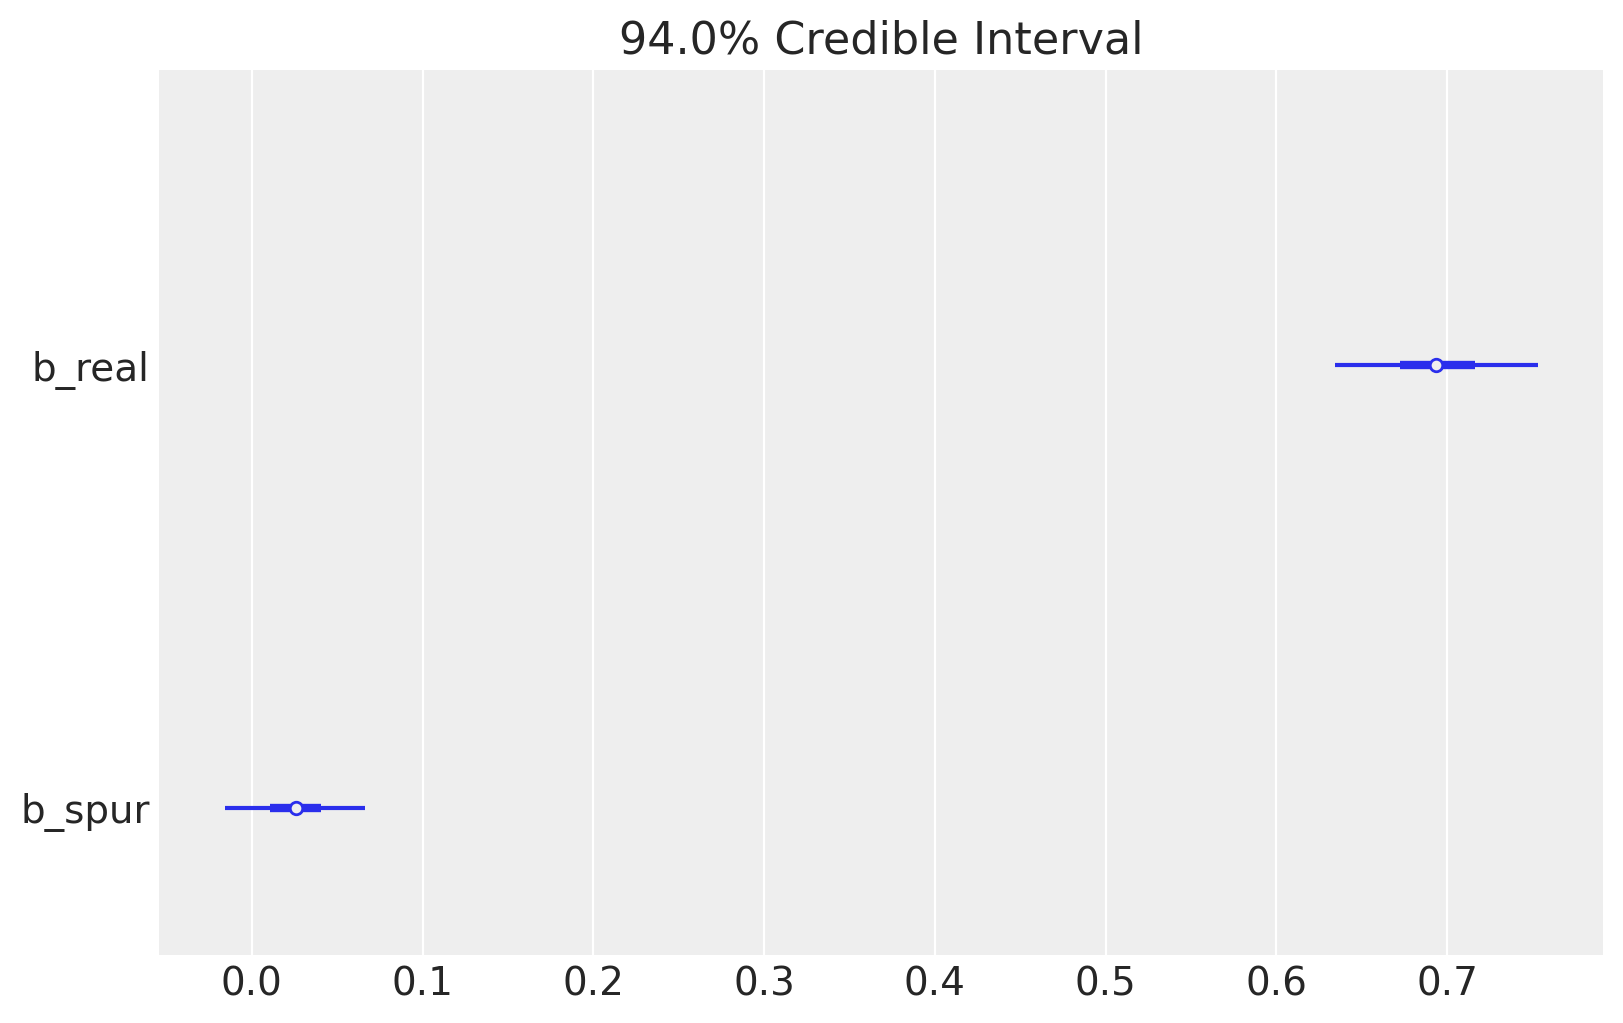

In [32]:
# plot results
axes = az.plot_forest(
    trace_m_sim,
    kind='forestplot',
    var_names=["b_real", "b_spur"],
    combined=True,
    ridgeplot_overlap=3,
    credible_interval=0.94,
    figsize=(8, 5))

### Code 5.19 - Code 5.26

In [33]:
# define model A->M and A -> D <- M
with pm.Model() as m5_3_A:
    # A -> D <- M
    sigma = pm.Exponential("sigma", 1)
    a = pm.Normal('a', mu=0, sigma=0.2)
    b_A = pm.Normal('b_A', mu=0, sigma=0.5)
    b_M = pm.Normal('b_M', mu=0, sigma=0.5)
    mu = pm.Deterministic("mu", a + b_A*d.MedianAgeMarriage_std + b_M*d.Marriage_std)
    Divorce = pm.Normal('Divorce', mu=mu, sigma=sigma, observed=d.Divorce_std)
   
    # A -> M
    sigma_M = pm.Exponential("sigma_M", 1)
    b_AM = pm.Normal("b_AM", mu=0, sigma=0.5)
    a_M = pm.Normal('a_M', mu=0, sigma=0.2)
    mu_M = pm.Deterministic("mu_M", a_M + b_AM*d.MedianAgeMarriage_std)
    Marriage = pm.Normal("Marriage", mu_M, sigma_M, observed=d.Marriage_std)

    m5_3_A_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_M, b_AM, sigma_M, b_M, b_A, a, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:03<00:00, 2190.88draws/s]


In [34]:
# show model summary
varnames = ['~mu', '~mu_M']
az.summary(m5_3_A_trace, varnames, kind="stats", round_to=2)

,mean,sd,hpd_3%,hpd_97%
a,0.00,0.10,-0.19,0.19
b_A,-0.61,0.15,-0.90,-0.32
b_M,-0.06,0.15,-0.35,0.22
b_AM,-0.69,0.10,-0.88,-0.51
a_M,-0.00,0.09,-0.17,0.17
sigma,0.83,0.09,0.68,0.99
sigma_M,0.71,0.08,0.58,0.86


In [35]:
#  simulate what would happen, if we manipulate A
A_seq = np.linspace(-2, 2, 50)
M_seq = np.linspace(-2, 2, 50)

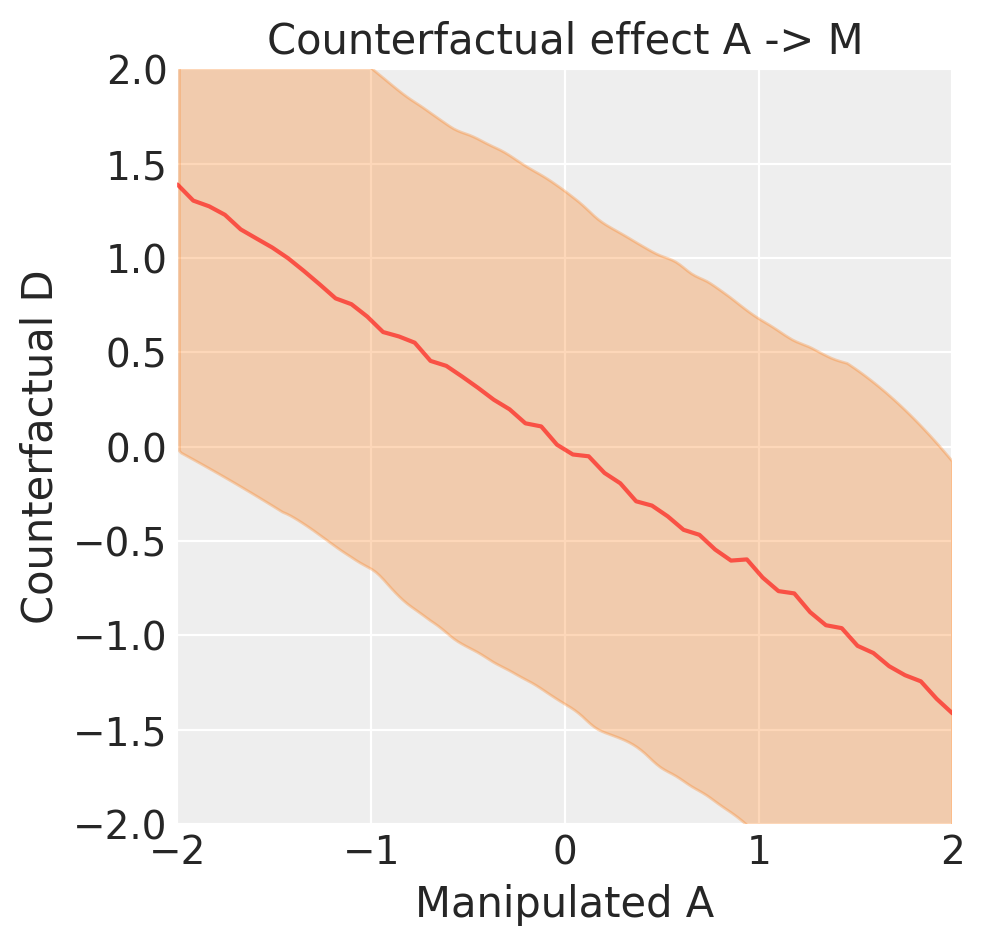

In [36]:
# simulating A → D  simulated values for M
post_samples_M = []
for _ in range(1000):  # number of samples from the posterior
    i = np.random.randint(len(m5_3_A_trace))
    mu_pr = m5_3_A_trace['a_M'][i] + m5_3_A_trace['b_AM'][i]*A_seq
    sigma_pred = m5_3_A_trace['sigma_M'][i]
    post_samples_M.append(np.random.normal(mu_pr, sigma_pred))

# plot results
fig = plt.figure(figsize=(5, 5))
# mean
plt.plot(A_seq, np.mean(post_samples_M, 0), "r", alpha=0.6)
# CI for mean
az.plot_hpd(A_seq, np.array(post_samples_M), color='C1', fill_kwargs={'alpha': 0.3})
plt.ylabel('Counterfactual D', fontsize=15)
plt.xlabel('Manipulated A', fontsize=15)
plt.title('Counterfactual effect A -> M', fontsize=15)
plt.ylim(-2, 2)
plt.xlim(-2, 2)
plt.show()

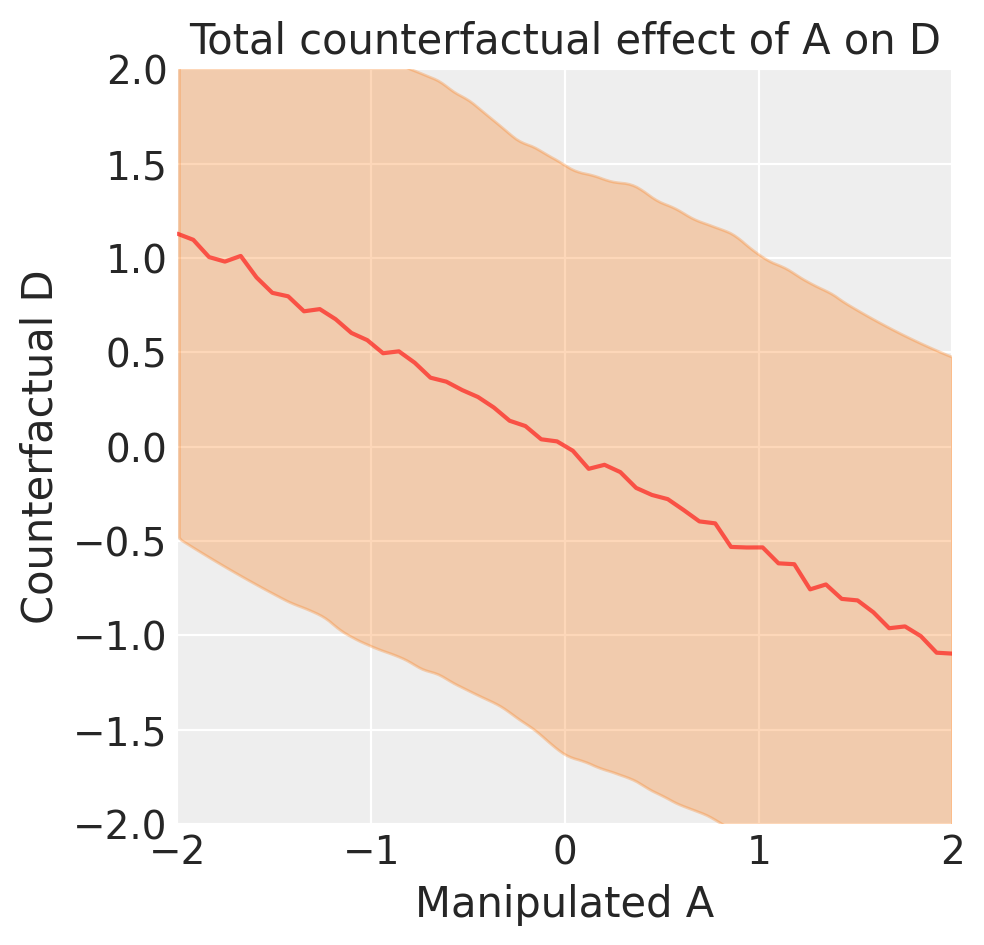

In [37]:
# simulating A → M → D  simulated values for D
post_samples_D = []
for _ in range(1000):  # number of samples from the posterior
    i = np.random.randint(len(m5_3_A_trace))
    mu_pr = m5_3_A_trace['a'][i] + m5_3_A_trace['b_A'][i]*A_seq + m5_3_A_trace['b_M'][i]*post_samples_M[i] 
    sigma_pred = m5_3_A_trace['sigma'][i]
    post_samples_D.append(np.random.normal(mu_pr, sigma_pred))

# plot results
fig = plt.figure(figsize=(5, 5))
# mean
plt.plot(A_seq, np.mean(post_samples_D, 0), "r", alpha=0.6)
# CI for mean
az.plot_hpd(A_seq, np.array(post_samples_D), color='C1', fill_kwargs={'alpha': 0.3})
plt.ylabel('Counterfactual D', fontsize=15)
plt.xlabel('Manipulated A', fontsize=15)
plt.title('Total counterfactual effect of A on D', fontsize=15)
plt.ylim(-2, 2)
plt.xlim(-2, 2)
plt.show()

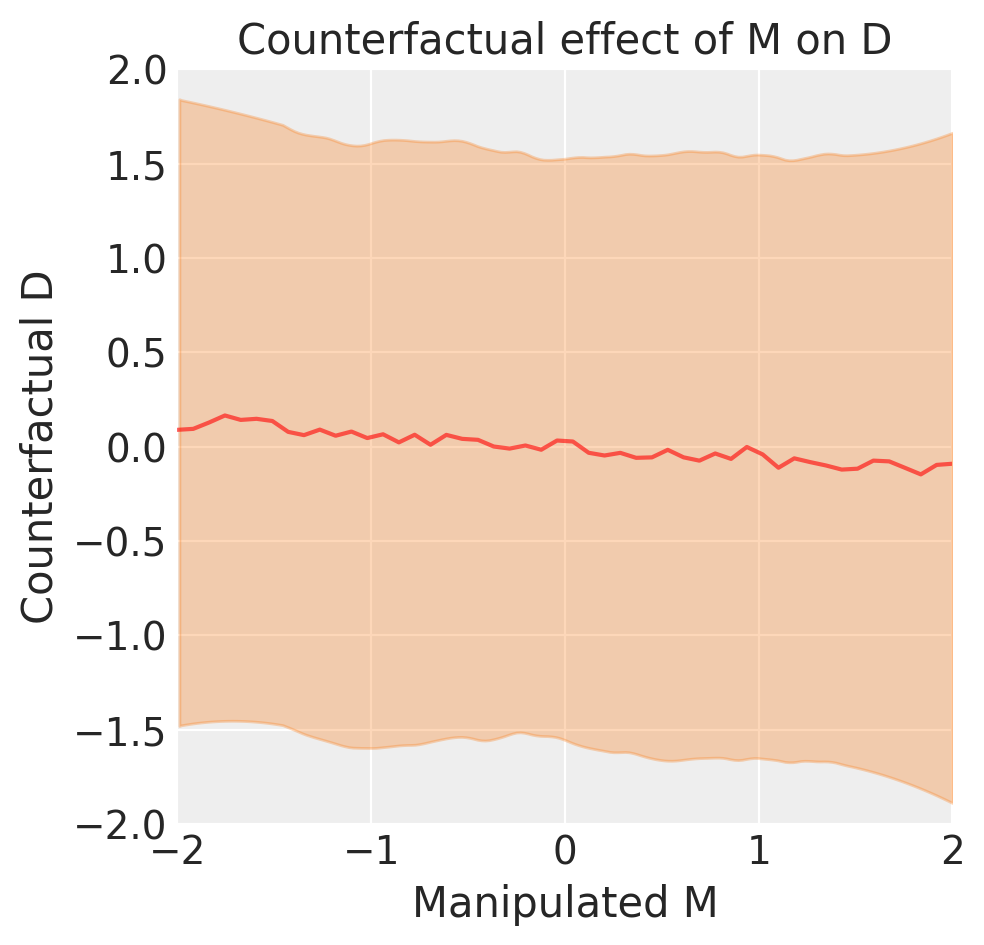

In [38]:
# simulating M → D 
post_samples = []
for _ in range(1000):  # number of samples from the posterior
    i = np.random.randint(len(m5_3_A_trace))
    mu_pr = m5_3_A_trace['a'][i] + m5_3_A_trace['b_M'][i]*M_seq
    sigma_pred = m5_3_A_trace['sigma'][i]
    post_samples.append(np.random.normal(mu_pr, sigma_pred))

# plot results
fig = plt.figure(figsize=(5, 5))
# mean
plt.plot(A_seq, np.mean(post_samples, 0), "r", alpha=0.6)
# CI for mean
az.plot_hpd(A_seq, np.array(post_samples), color='C1', fill_kwargs={'alpha': 0.3})
plt.ylabel('Counterfactual D', fontsize=15)
plt.xlabel('Manipulated M', fontsize=15)
plt.title('Counterfactual effect of M on D', fontsize=15)
plt.ylim(-2, 2)
plt.xlim(-2, 2)
plt.show()

## 5.2. Masked relationship


### Code 5.27

In [39]:
# load milk data
d = pd.read_csv("Data/milk.csv", sep=";", header=0)
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


### Code 5.28 - Code 5.32

In [40]:
# standardize data
d["K"] = (d["kcal.per.g"]-d["kcal.per.g"].mean())/d["kcal.per.g"].std()
d["N"] = (d["neocortex.perc"]-d["neocortex.perc"].mean())/d["neocortex.perc"].std()
d["M"] = (np.log(d["mass"])-np.log(d["mass"]).mean())/np.log(d["mass"]).std()

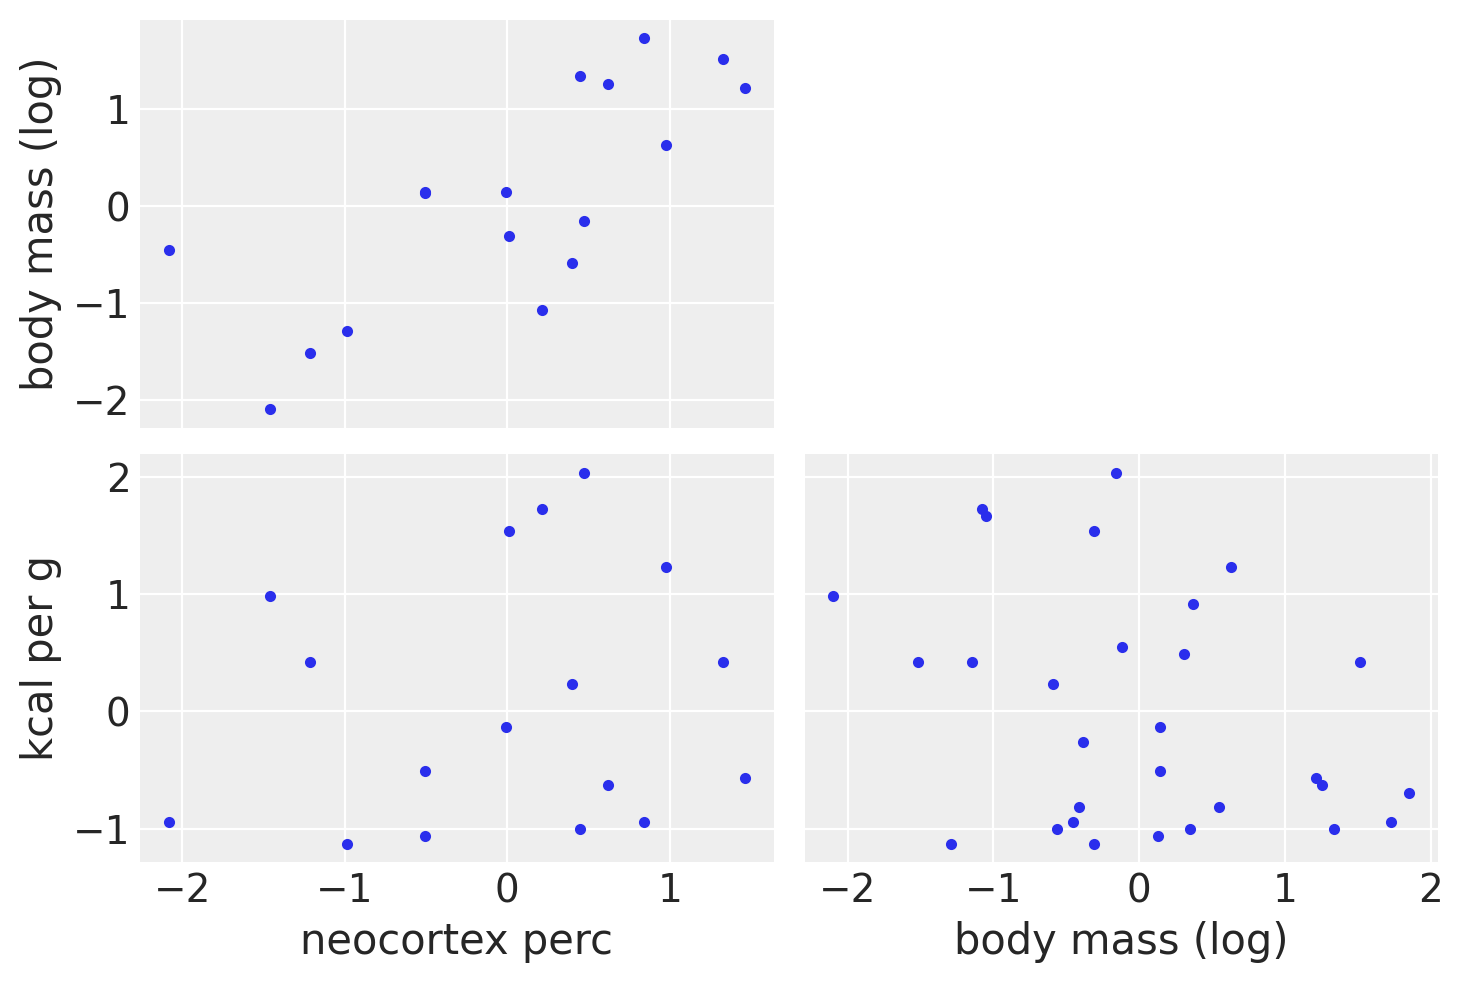

In [41]:
# drop NaN values
dcc = d.dropna(axis=0)
# show plots
az.plot_pair(
    {"neocortex perc":d["N"], 
    "body mass (log)":d["M"],
    "kcal per g":d["K"]}
)
plt.show()

In [42]:
# define model of kilocalories and neocortex percent
with pm.Model() as m5_5_draft:
    a = pm.Normal("a", mu=0, sigma=1)
    bN = pm.Normal("bN", mu=0, sigma=1)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + bN*dcc["N"])
    K = pm.Normal("K", mu=mu, sigma=sigma, observed=dcc["K"])
    m5_5_draft_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bN, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:01<00:00, 4593.65draws/s]


### Code 5.33

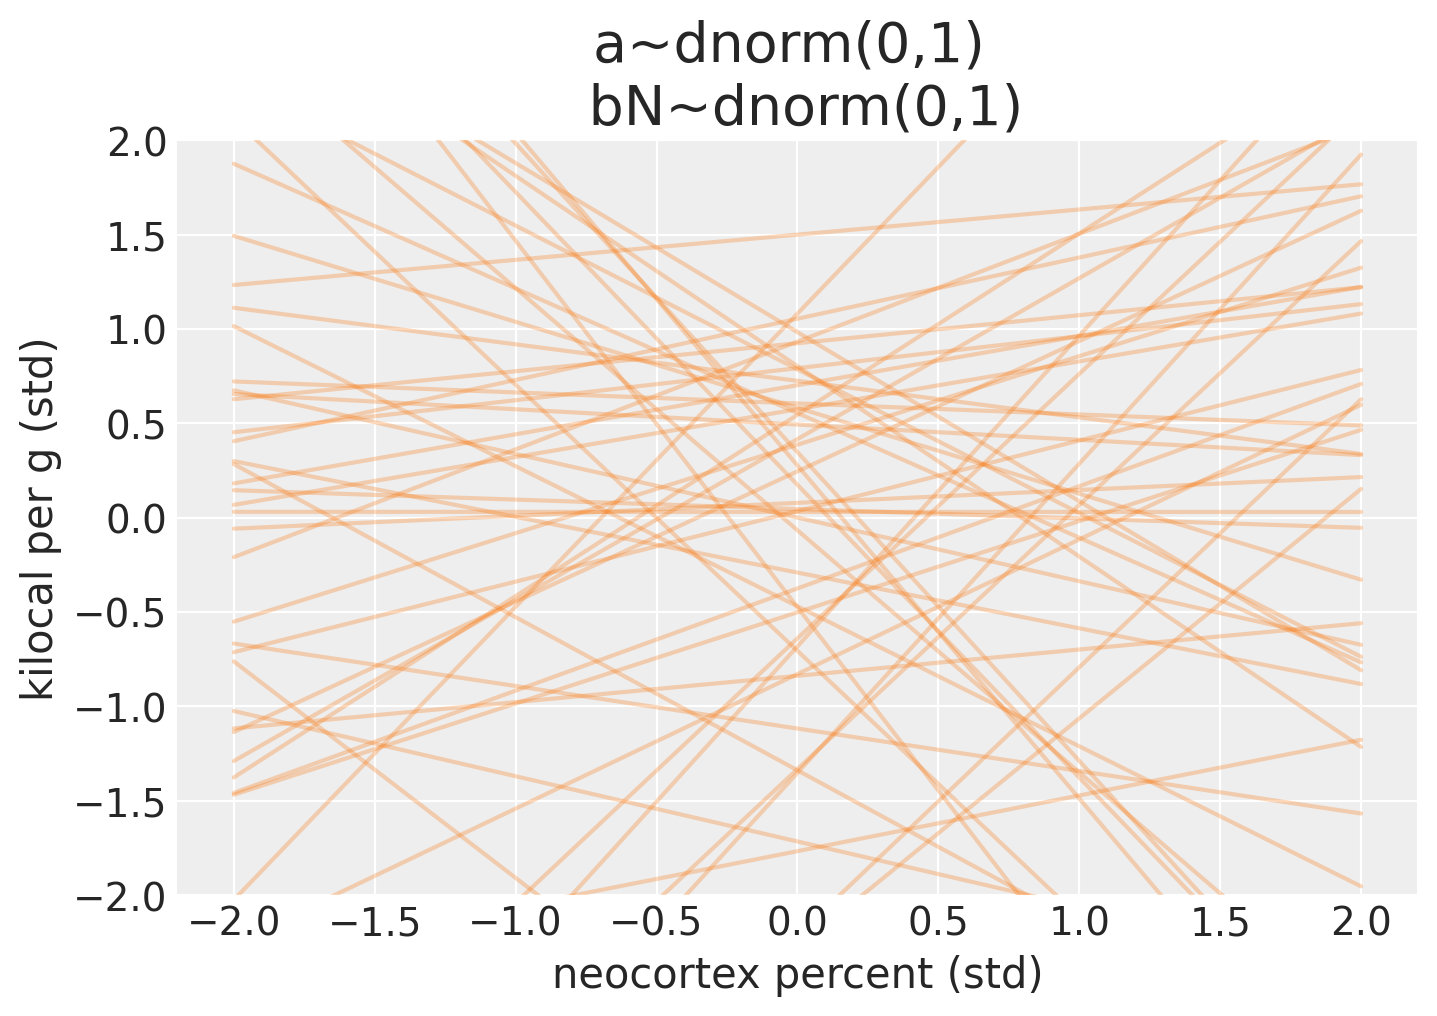

In [43]:
# simulate priors 
n_samples = 1000
sample_a = stats.norm.rvs(loc=0, scale=1, size=n_samples)
sample_bN = stats.norm.rvs(loc=0, scale=1, size=n_samples)

# simulate priors
x_seq = np.linspace(-2, 2, 100)

# calculate posterior for each mu
mu_pred = np.zeros((len(x_seq), n_samples))
for n, x in enumerate(x_seq):
    mu_pred[n] = sample_a + sample_bN*x

# plot results
fig = plt.figure(figsize=(8, 5))
plt.plot(x_seq, mu_pred[:,:50], "-C1", alpha=0.3)
plt.ylabel('kilocal per g (std)', fontsize=15)
plt.xlabel('neocortex percent (std)', fontsize=15)
plt.ylim(-2, 2)
plt.title('a~dnorm(0,1) \n bN~dnorm(0,1)', fontsize=20)
plt.show()

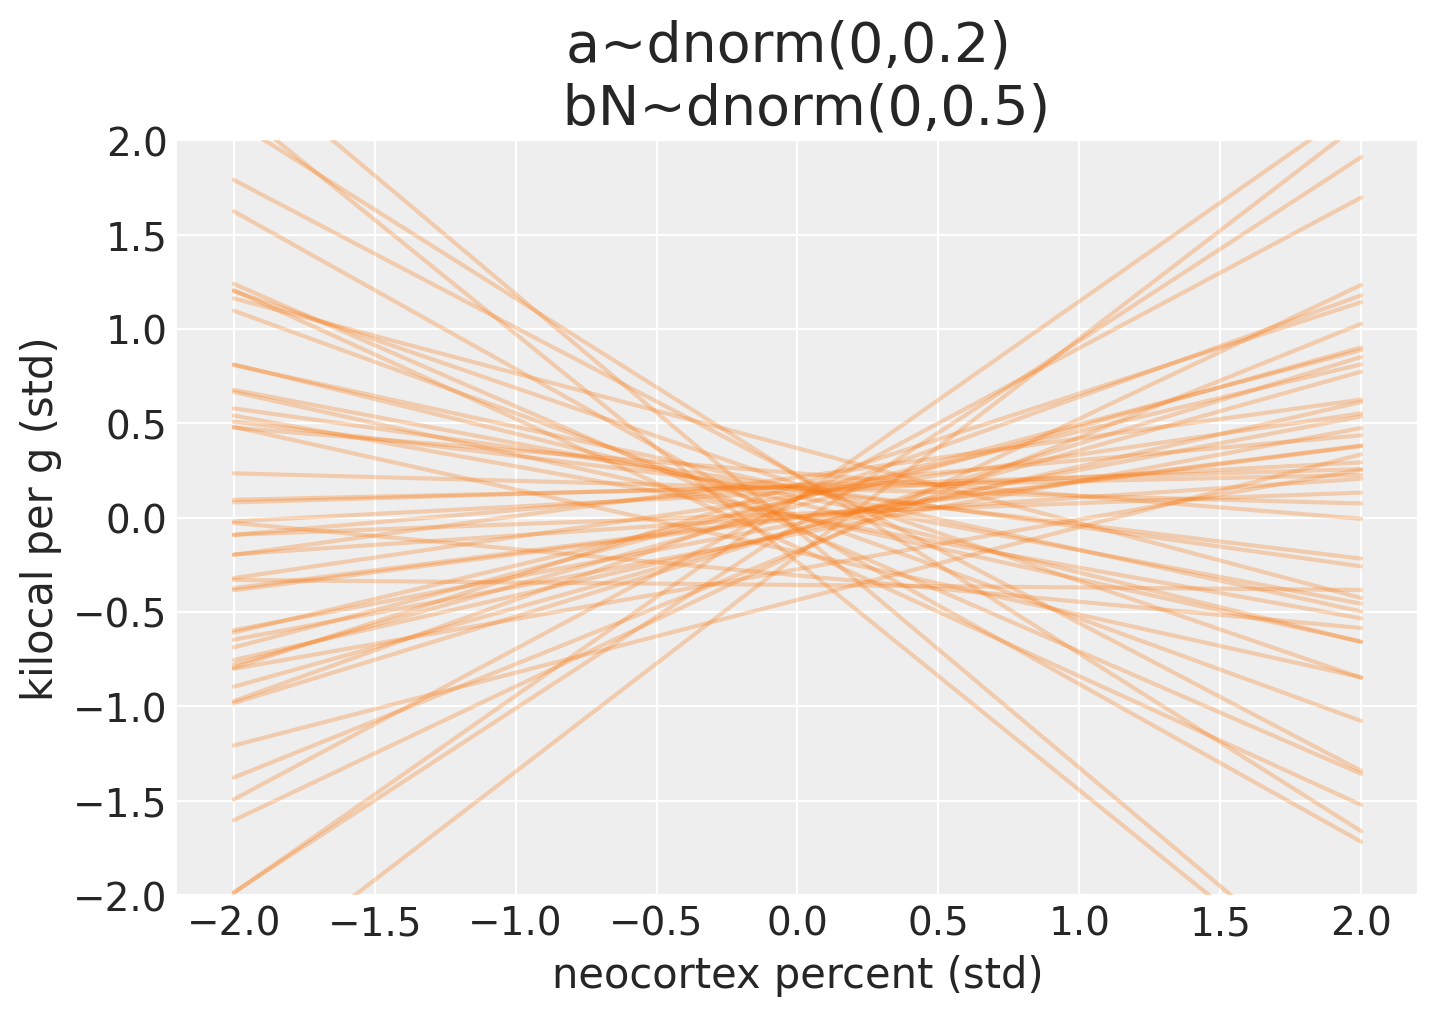

In [44]:
# simulate priors 
n_samples = 1000
sample_a = stats.norm.rvs(loc=0, scale=0.2, size=n_samples)
sample_bN = stats.norm.rvs(loc=0, scale=0.5, size=n_samples)

# simulate priors
x_seq = np.linspace(-2, 2, 100)

# calculate posterior for each mu
mu_pred = np.zeros((len(x_seq), n_samples))
for n, x in enumerate(x_seq):
    mu_pred[n] = sample_a + sample_bN*x

# plot results
fig = plt.figure(figsize=(8, 5))
plt.plot(x_seq, mu_pred[:,:50], "-C1", alpha=0.3)
plt.ylabel('kilocal per g (std)', fontsize=15)
plt.xlabel('neocortex percent (std)', fontsize=15)
plt.ylim(-2, 2)
plt.title('a~dnorm(0,0.2) \n bN~dnorm(0,0.5)', fontsize=20)
plt.show()

### Code 5.34 and Code 5.37

In [45]:
# define model of kilocalories and neocortex percent
with pm.Model() as m5_5_K_N:
    a = pm.Normal("a", mu=0, sigma=0.2)
    bN = pm.Normal("bN", mu=0, sigma=0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + bN*dcc["N"])
    K = pm.Normal("K", mu=mu, sigma=sigma, observed=dcc["K"])
    m5_5_K_N_trace = pm.sample(1000, tune=1000)

# show model summary
varnames = ['~mu']
az.summary(m5_5_K_N_trace, varnames, kind="stats", round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bN, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:01<00:00, 4568.01draws/s]


,mean,sd,hpd_3%,hpd_97%
a,0.04,0.16,-0.26,0.34
bN,0.13,0.25,-0.32,0.60
sigma,1.11,0.21,0.75,1.49


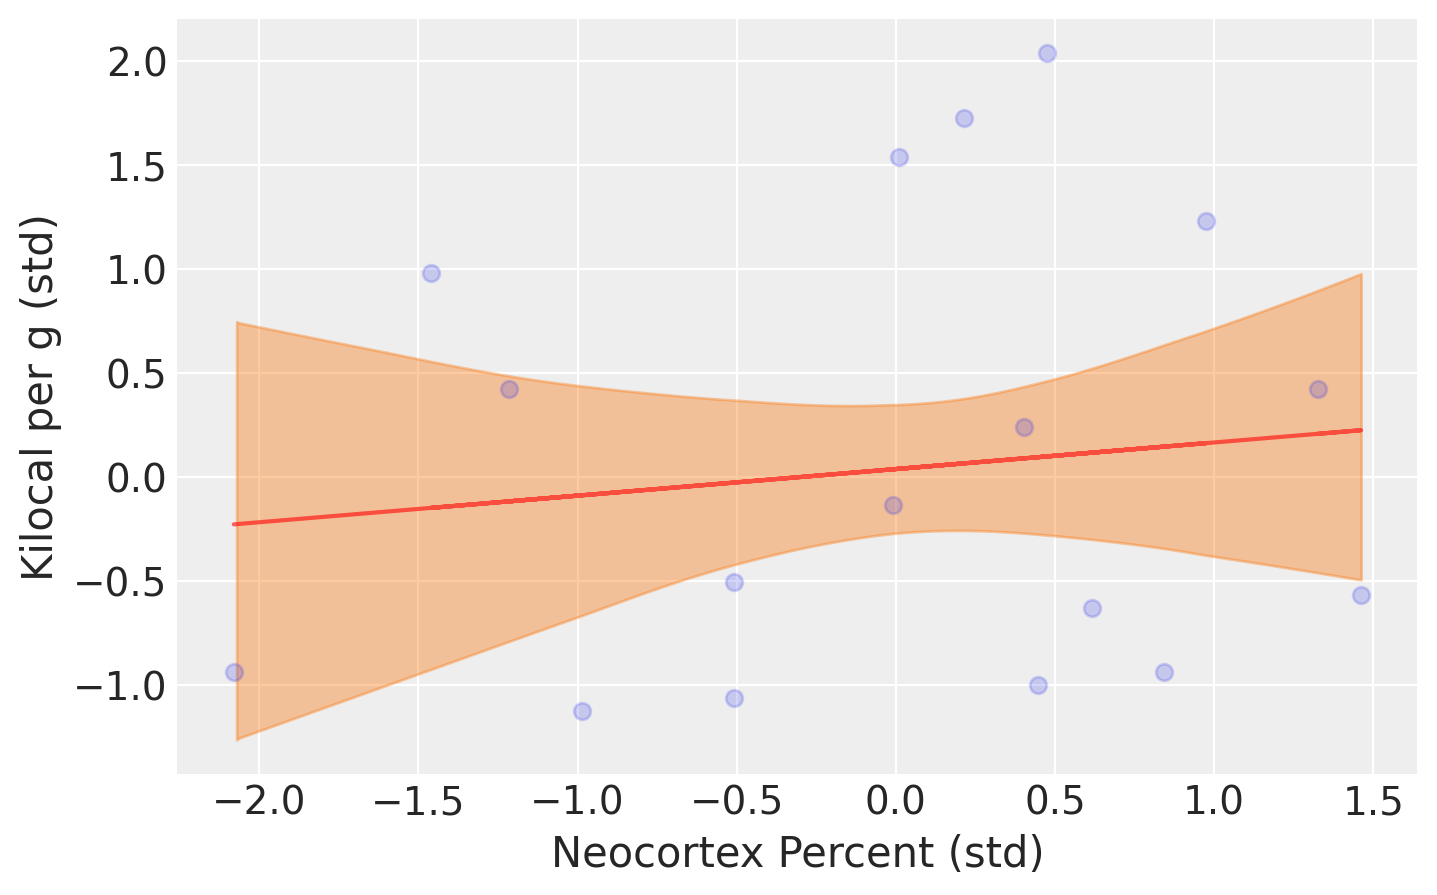

In [46]:
# plot results
fig = plt.figure(figsize=(8, 5))
plt.plot(dcc["N"], dcc["K"], 'o', alpha=0.2)
# mean
plt.plot(dcc["N"], m5_5_K_N_trace['mu'].mean(0), "r", alpha=0.6)
# CI for mean
az.plot_hpd(dcc["N"], m5_5_K_N_trace['mu'], color='C1', fill_kwargs={'alpha': 0.4})
plt.ylabel('Kilocal per g (std)', fontsize=15)
plt.xlabel('Neocortex Percent (std)', fontsize=15)
#plt.xlim(-2, 1.5)
plt.show()

In [47]:
# define model of kilocalories and body mass
with pm.Model() as m5_5_K_M:
    a = pm.Normal("a", mu=0, sigma=0.2)
    bM = pm.Normal("bM", mu=0, sigma=0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + bM*dcc["M"])
    K = pm.Normal("K", mu=mu, sigma=sigma, observed=dcc["K"])
    m5_5_K_M_trace = pm.sample(1000, tune=1000)

# show model summary
varnames = ['~mu']
az.summary(m5_5_K_M_trace, varnames, kind="stats", round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bM, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:01<00:00, 4212.29draws/s]


,mean,sd,hpd_3%,hpd_97%
a,0.05,0.16,-0.24,0.34
bM,-0.27,0.22,-0.69,0.12
sigma,1.06,0.20,0.75,1.43


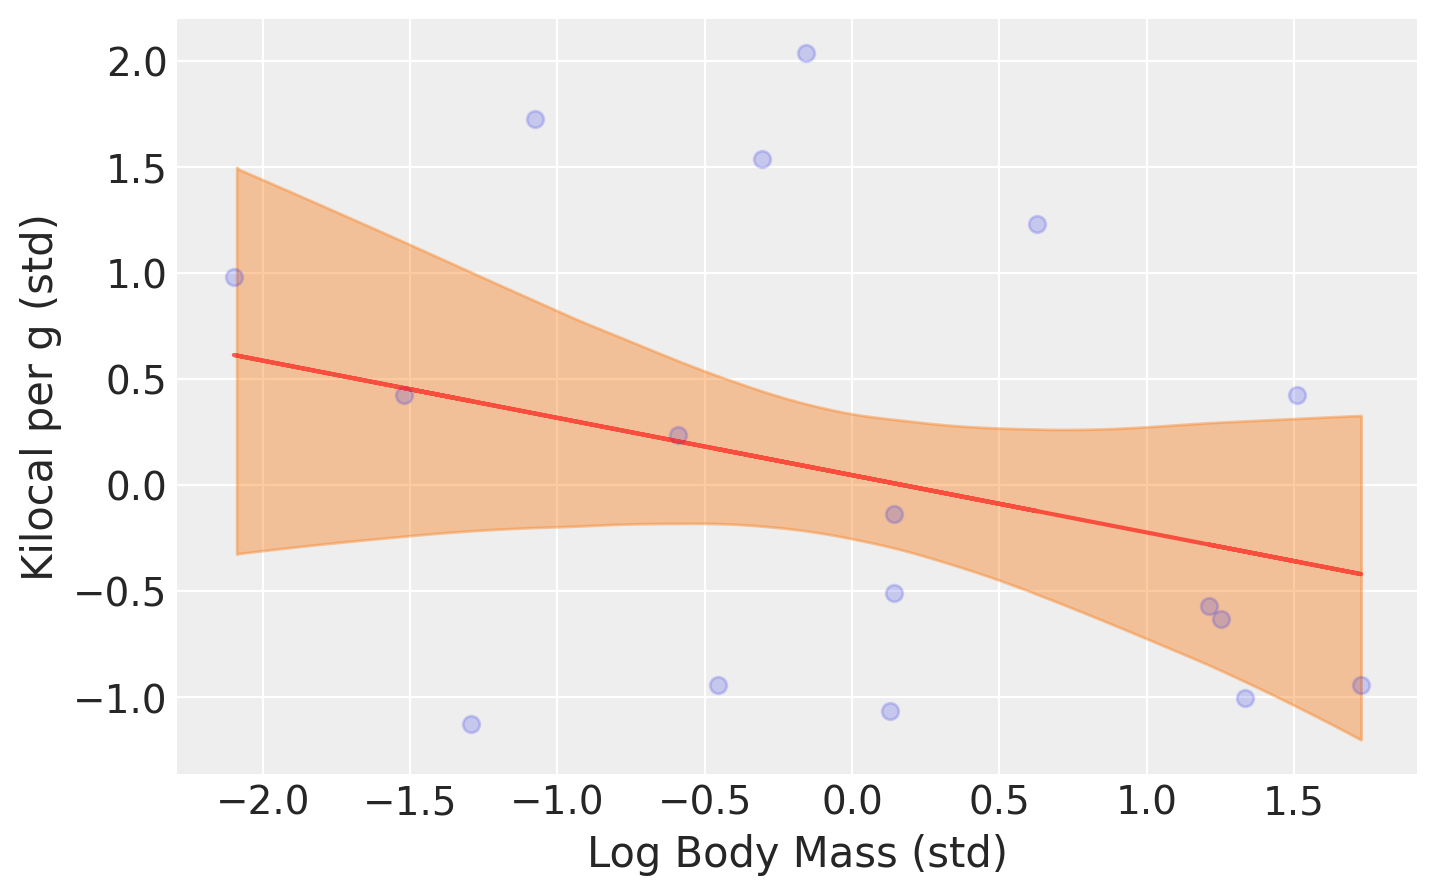

In [48]:
# plot results
fig = plt.figure(figsize=(8, 5))
plt.plot(dcc["M"], dcc["K"], 'o', alpha=0.2)
# mean
plt.plot(dcc["M"], m5_5_K_M_trace['mu'].mean(0), "r", alpha=0.6)
# CI for mean
az.plot_hpd(dcc["M"], m5_5_K_M_trace['mu'], color='C1', fill_kwargs={'alpha': 0.4})
plt.ylabel('Kilocal per g (std)', fontsize=15)
plt.xlabel('Log Body Mass (std)', fontsize=15)
#plt.xlim(-2, 1.5)
plt.show()

### Code 5.38

In [49]:
# define model of kilocalories and neocortex percent + body mass
shared_N = shared(dcc["N"].values)
shared_M = shared(dcc["M"].values)

with pm.Model() as m5_7:
    a = pm.Normal("a", mu=0, sigma=0.2)
    bN = pm.Normal("bN", mu=0, sigma=0.5)
    bM = pm.Normal("bM", mu=0, sigma=0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + bN*shared_N + bM*shared_M)
    K = pm.Normal("K", mu=mu, sigma=sigma, observed=dcc["K"])
    m5_7_trace = pm.sample(1000, tune=1000)

# show model summary
varnames = ['~mu']
az.summary(m5_7_trace, varnames, kind="stats", round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bM, bN, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 3126.55draws/s]


,mean,sd,hpd_3%,hpd_97%
a,0.06,0.15,-0.22,0.34
bN,0.60,0.28,0.06,1.10
bM,-0.64,0.25,-1.08,-0.16
sigma,0.86,0.18,0.57,1.19


### Code 3.39

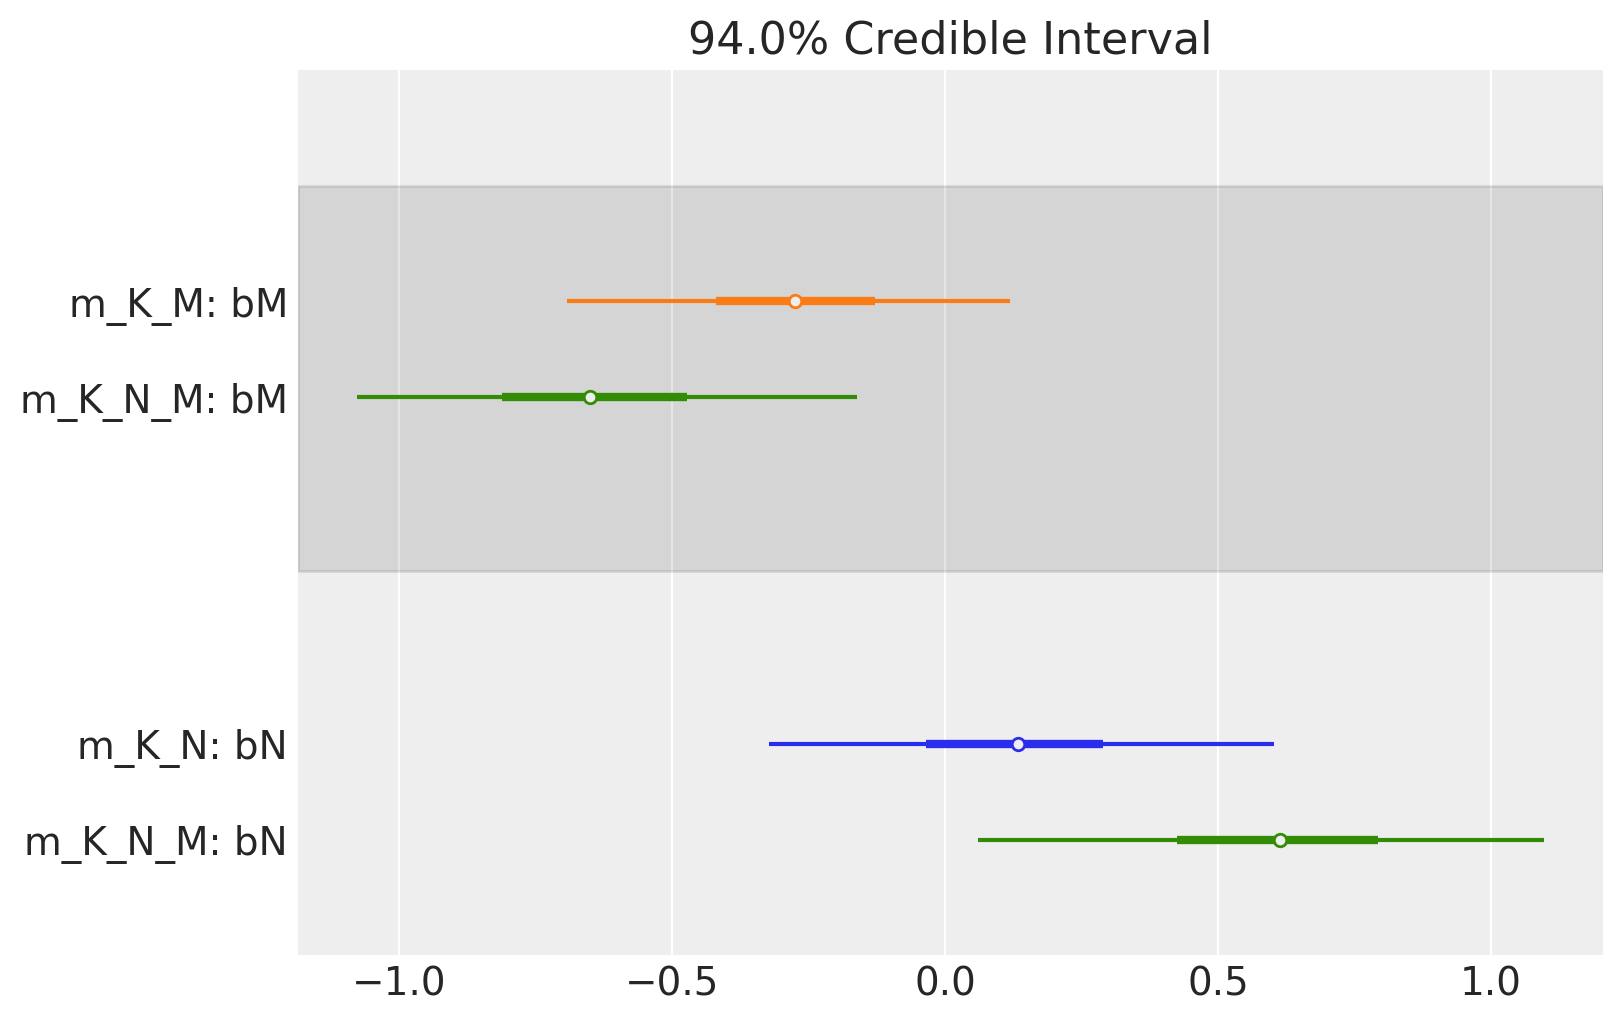

In [50]:
# plot results
axes = az.plot_forest(
    [m5_5_K_N_trace, m5_5_K_M_trace, m5_7_trace],
    kind='forestplot',
    model_names=["m_K_N", "m_K_M", "m_K_N_M"],
    var_names=["bM", "bN"],
    combined=True,
    ridgeplot_overlap=3,
    credible_interval=0.94,
    figsize=(8, 5))

### Code 5.40

/Users/yifei-wang/.pyenv/versions/3.7.4/envs/Statistical_Rethinking/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:00<00:00, 2634.70it/s]


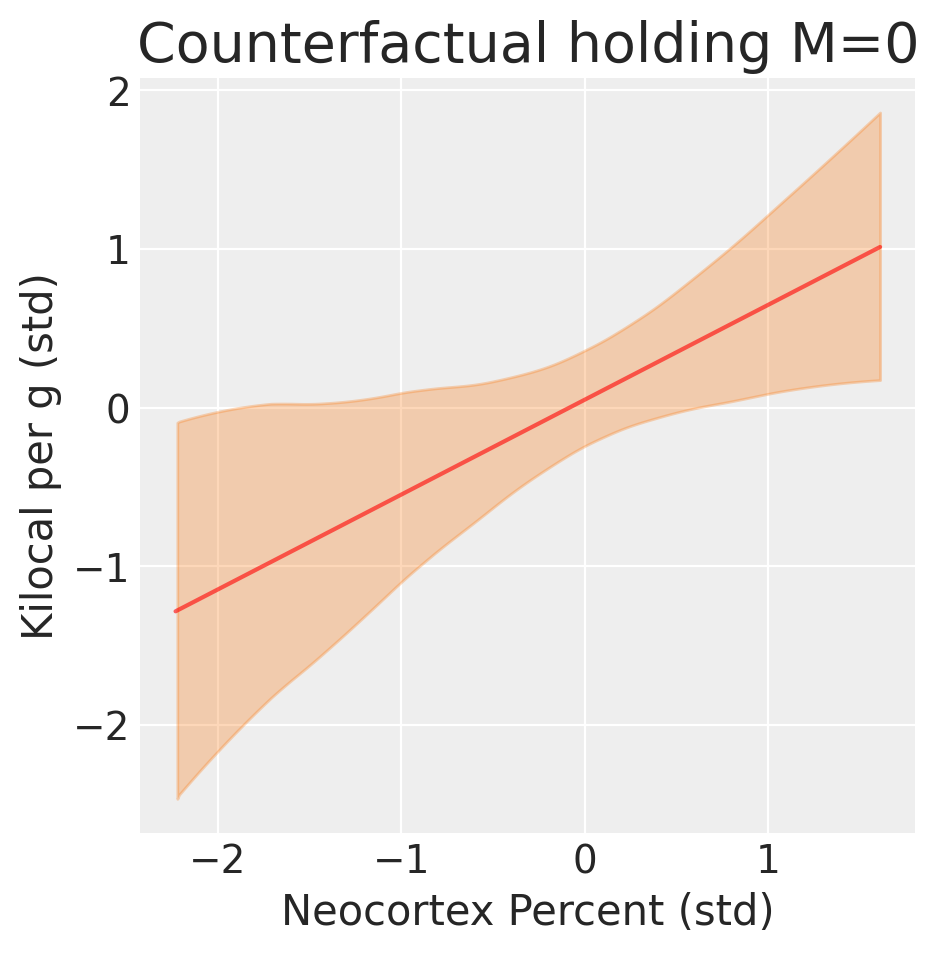

In [51]:
# counterfactual plot M=0
N_seq = np.linspace(dcc['N'].min()-0.15, dcc['N'].max()+0.15, 30)

# change values in model
shared_N.set_value(N_seq)
shared_M.set_value(np.zeros(30))

with m5_7:
    K_post = pm.sample_posterior_predictive(
        trace = m5_7_trace, 
        var_names=["mu"], 
        samples=1000
    )

# plot results
fig = plt.figure(figsize=(5, 5))
# mean
plt.plot(N_seq, K_post['mu'].mean(0), "r", alpha=0.6)
# CI for mean
az.plot_hpd(N_seq, K_post['mu'], color='C1', fill_kwargs={'alpha': 0.3})
plt.ylabel('Kilocal per g (std)', fontsize=15)
plt.xlabel('Neocortex Percent (std)', fontsize=15)
plt.title('Counterfactual holding M=0', fontsize=20)
plt.show()

/Users/yifei-wang/.pyenv/versions/3.7.4/envs/Statistical_Rethinking/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:00<00:00, 2491.58it/s]


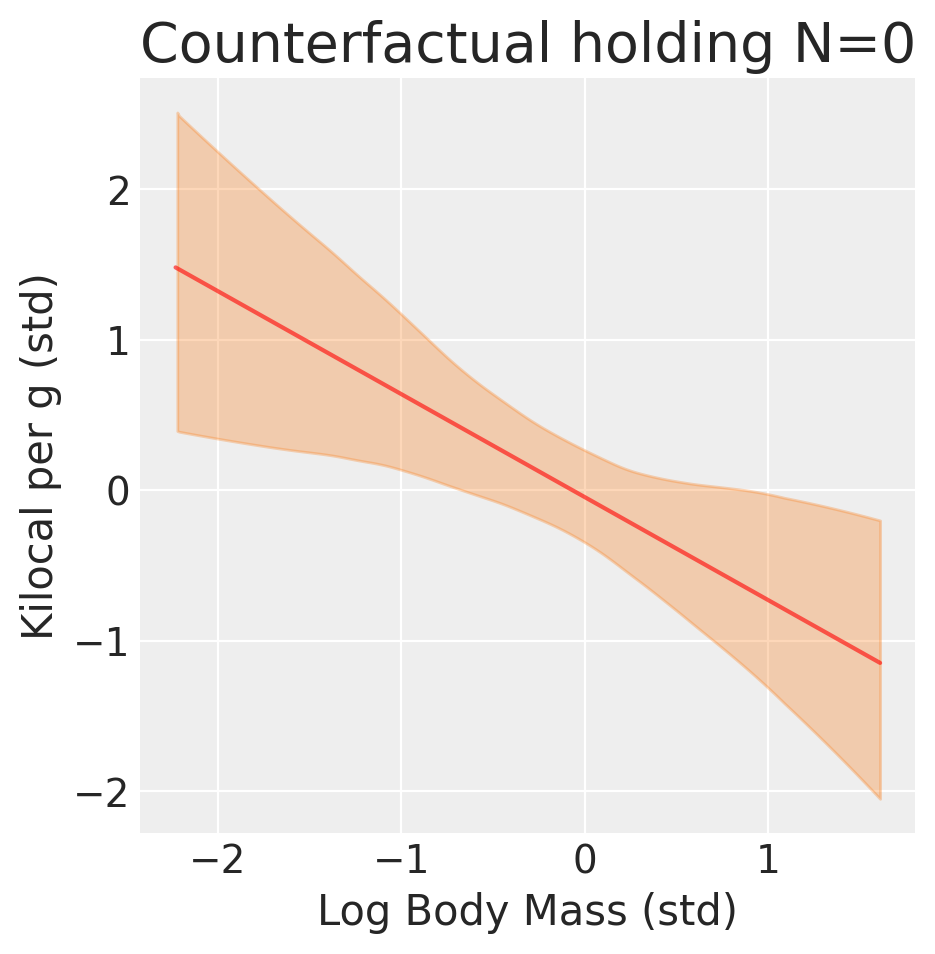

In [52]:
# counterfactual plot N=0
M_seq = np.linspace(dcc['M'].min()-0.15, dcc['M'].max()+0.15, 30)

# change values in model
shared_M.set_value(M_seq)
shared_N.set_value(np.zeros(30))

with m5_7:
    K_post = pm.sample_posterior_predictive(
        trace = m5_7_trace, 
        var_names=["mu"], 
        samples=1000
    )

# plot results
fig = plt.figure(figsize=(5, 5))
# mean
plt.plot(N_seq, K_post['mu'].mean(0), "r", alpha=0.6)
# CI for mean
az.plot_hpd(N_seq, K_post['mu'], color='C1', fill_kwargs={'alpha': 0.3})
plt.ylabel('Kilocal per g (std)', fontsize=15)
plt.xlabel('Log Body Mass (std)', fontsize=15)
plt.title('Counterfactual holding N=0', fontsize=20)
plt.show()

### Code 5.41


In [53]:
# M -> K <- N
# M -> N

n = 100
M = stats.norm().rvs(n)
N = stats.norm(M).rvs(n)
K = stats.norm(N - M).rvs(n)
d_sim = pd.DataFrame({"K": K, "M": M, "N": N})
d_sim.head()

,K,M,N
0,0.090743,2.222399,3.284060
1,-0.868209,0.210529,0.911172
2,0.175518,-0.109426,0.214312
3,1.103211,-1.037890,0.542179
4,0.280723,0.074196,-0.334579


### Code 5.42

In [54]:
# M -> K <- N
# N -> M

n = 100
N = stats.norm().rvs(n)
M = stats.norm(N).rvs(100)
K = stats.norm(N - M).rvs(100)
d_sim2 = pd.DataFrame({"K": K, "M": M, "N": N})
d_sim2.head()

,K,M,N
0,2.159653,-0.052995,-0.507931
1,0.669389,-1.060757,-1.750668
2,-3.011578,1.620723,-0.047784
3,0.942475,-0.970572,-0.404335
4,-0.992678,1.325013,1.199689


In [55]:
# M -> K <- N
# M <- U -> N

n = 100
U = stats.norm().rvs(n)
N = stats.norm(U).rvs(n)
M = stats.norm(U).rvs(100)
K = stats.norm(N - M).rvs(100)
d_sim3 = pd.DataFrame({"K": K, "M": M, "N": N})
d_sim3.head()

,K,M,N
0,-5.137698,3.480603,-1.230298
1,-5.171716,2.446170,-1.833852
2,-2.338305,1.616503,-0.002492
3,0.882815,-1.657596,-0.662204
4,-0.227415,0.538383,1.953499


### Code 5.43

Drawing a DAG Visit http://www.dagitty.net/.

## 5.3. Categorical variables

### 5.3.1. Binary categories

### Code 5.44

In [56]:
# partial census data by Nancy Howell
d = pd.read_csv("Data/Howell1.csv", sep=";", header=0)
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


### Code 5.45

In [57]:
mu_female = stats.norm(178, 20).rvs(1000)
mu_male = stats.norm(178, 20).rvs(1000) + stats.norm(0, 10).rvs(1000)

az.summary({"mu_female": mu_female, "mu_male": mu_male}, kind="stats", round_to=2)

,mean,sd,hpd_3%,hpd_97%
mu_female,177.92,19.30,143.06,212.35
mu_male,177.15,22.77,132.39,216.53


### Code 5.46 and Code 5.47

In [58]:
sex = d["male"].values

with pm.Model() as m5_8:
    mu = pm.Normal("mu", mu=178, sd=20, shape=2)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    height = pm.Normal("height", mu=mu[sex], sd=sigma, observed=d["height"])
    m5_8_trace = pm.sample(1000, tune=1000)
    
az.summary(m5_8_trace, kind="stats", round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:01<00:00, 4166.38draws/s]


,mean,sd,hpd_3%,hpd_97%
mu[0],134.93,1.61,132.06,138.07
mu[1],142.58,1.74,139.29,145.70
sigma,27.40,0.85,25.82,29.01


### Code 5.48

In [59]:
# With PyMC3 it's easier just to create a deterministic that includes both values
sex = d["male"].values

with pm.Model() as m5_8:
    mu = pm.Normal("mu", mu=178, sd=20, shape=2)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    height = pm.Normal("height", mu=mu[sex], sd=sigma, observed=d["height"])
    diff_fm = pm.Deterministic("diff", mu[0] - mu[1])
    m5_8_trace = pm.sample(1000, tune=1000)

az.summary(m5_8_trace, kind="stats", round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:01<00:00, 4313.08draws/s]


,mean,sd,hpd_3%,hpd_97%
mu[0],134.90,1.67,131.77,137.97
mu[1],142.57,1.77,139.08,145.78
sigma,27.43,0.85,25.96,29.10
diff,-7.67,2.39,-11.95,-3.21


### 5.3.2. Many categories

### Coode 5.49

In [60]:
 # load milk data
d = pd.read_csv("Data/milk.csv", sep=";", header=0)
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


In [61]:
np.unique(d.clade)

array(['Ape', 'New World Monkey', 'Old World Monkey', 'Strepsirrhine'],
      dtype=object)

### Code 5.50

In [62]:
d["clade_id"] = pd.Categorical(d["clade"]).codes
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc,clade_id
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16,3
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN,3
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN,3
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN,3
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN,3


### Code 5.51

In [63]:
d["K"] = (d["kcal.per.g"]-d["kcal.per.g"].mean())/d["kcal.per.g"].std()

In [69]:
with pm.Model() as m5_9:
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Normal("mu", mu=0, sd=0.5, shape=d["clade_id"].max()+1)
    K = pm.Normal("K", mu=mu[d["clade_id"].values], sd=sigma, observed=d["K"])
    m5_9_trace = pm.sample(1000, tune=1000)

az.summary(m5_9_trace, kind="stats", round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:01<00:00, 4271.06draws/s]


,mean,sd,hpd_3%,hpd_97%
mu[0],-0.46,0.24,-0.93,-0.02
mu[1],0.35,0.23,-0.07,0.79
mu[2],0.64,0.28,0.11,1.15
mu[3],-0.55,0.30,-1.10,0.01
sigma,0.80,0.12,0.60,1.03


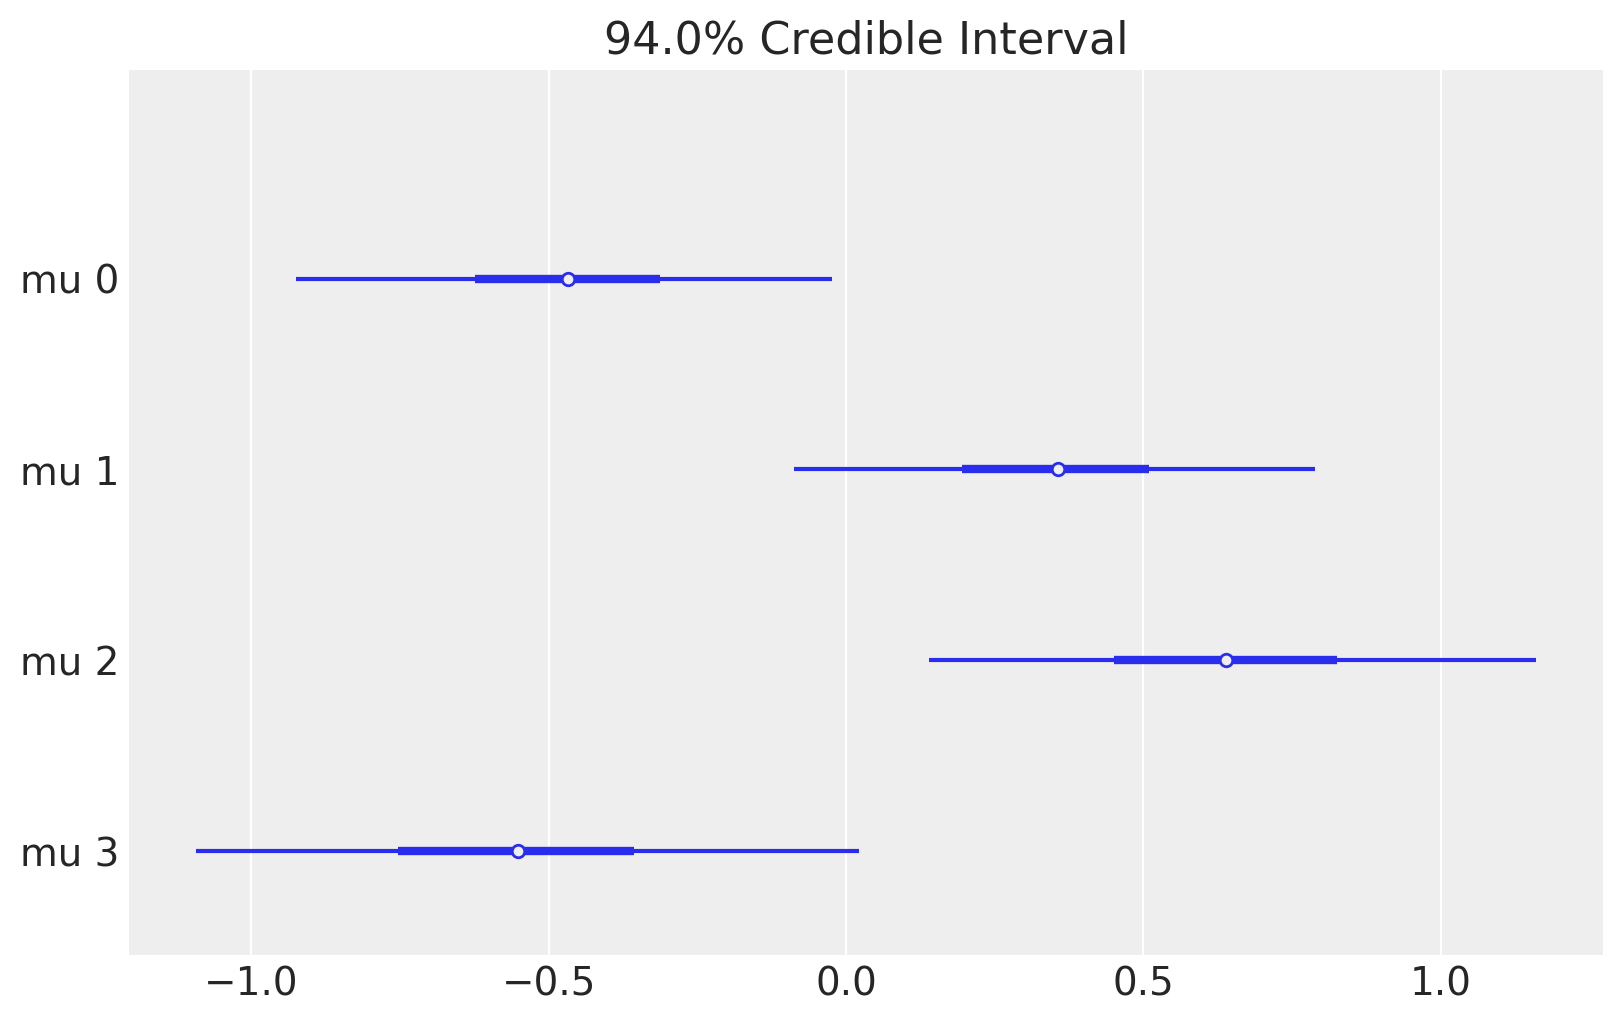

In [66]:
# plot results
axes = az.plot_forest(
    m5_9_trace,
    kind='forestplot',
    var_names=["mu"],
    combined=True,
    ridgeplot_overlap=3,
    credible_interval=0.94,
    figsize=(8, 5))

### Code 5.52

In [67]:
d["house"] = np.random.randint(0, 4, size=d.shape[0])

### Code 5.53

In [68]:
with pm.Model() as m5_10:
    sigma = pm.Exponential("sigma", 1)
    mu_house = pm.Normal("mu_house", mu=0, sd=0.5, shape=d["house"].max()+1)
    mu_clade = pm.Normal("mu_clade", mu=0, sd=0.5, shape=d["clade_id"].max()+1)
    
    K = pm.Normal("K", mu=mu_house[d["house"].values]+mu_clade[d["clade_id"].values], sd=sigma, observed=d["K"])
    m5_10_trace = pm.sample(1000, tune=1000)

az.summary(m5_10_trace, kind="stats", round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_clade, mu_house, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 2928.63draws/s]


,mean,sd,hpd_3%,hpd_97%
mu_house[0],-0.10,0.31,-0.69,0.46
mu_house[1],0.03,0.33,-0.58,0.64
mu_house[2],-0.19,0.29,-0.79,0.33
mu_house[3],0.24,0.28,-0.27,0.80
mu_clade[0],-0.48,0.29,-1.00,0.06
mu_clade[1],0.36,0.29,-0.17,0.89
mu_clade[2],0.68,0.32,0.07,1.29
mu_clade[3],-0.57,0.32,-1.17,0.06
sigma,0.79,0.12,0.57,1.02


### Reference¶


[pymc-devs: Chp05](https://github.com/pymc-devs/resources/blob/master/Rethinking_2/Chp_05.ipynb)